In [138]:
import pandas as pd
import yfinance as yf
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import pickle
from scipy.signal import butter,filtfilt
from tslearn.clustering import TimeSeriesKMeans
from matplotlib import colors as mcolors
from sklearn.linear_model import LinearRegression
from random import sample

In [152]:
def preprocess(data):
    data=data['Adj Close']
    data=data.reset_index()
    data=data.rename(columns={ 'Date': 'date'})
    data_dict={}
    tics=[tic for tic in data.columns][1:]
    for tic in tics:
        temp=data.loc[:,['date',tic]]
        temp.rename(columns={tic:'adjcp'},inplace=True)
        temp=temp.assign(pct_return=temp['adjcp'].pct_change().fillna(0))
        data_dict[tic]=temp
    return data_dict,tics

In [195]:
def apply_to_all(tics,dataset,function):
    for tic in tics:
        function(dataset[tic])
def plot_ori(data,name):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10),constrained_layout=True)
    if isinstance(data['date'][0],str):
        date=data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    else:
        date=data['date']
    ax.plot(date, data['adjcp'])
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M'))
    ax.set_title(name+'_adjcp',fontsize=20)
    ax.grid(True)
    fig.savefig('res/'+name+'_adjcp'+'.png')
def plot_pct(data,name):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10),constrained_layout=True)
    if isinstance(data['date'][0],str):
        date=data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    else:
        date=data['date']
    ax.plot(date, data['pct_return'])
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M'))
    ax.set_title(name+'pct_return',fontsize=20)
    ax.grid(True)
    fig.savefig('res/'+name+'_pct_return'+'.png')
def plot_both(data,name):
    plot_ori(data,name)
    plot_pct(data,name)
    
    
def plot_filter(data,name,low=6, high=32, K=12):
    # see sm.tsa.filters.bkfilter for more detail, this method is not applied to the pipline for now
    filtered_data=sm.tsa.filters.bkfilter(data[['adjcp','pct_return']],low,high,K)
    if isinstance(data['date'][0],str):
        date=data['date'][K:-K].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    else:
        date=data['date'][K:-K]
    fig, ax = plt.subplots(2, 1, figsize=(20, 10),constrained_layout=True)
    ax[0].plot(date,filtered_data['adjcp_cycle'],label='adjcp_cycle')
    ax[1].plot(date,filtered_data['pct_return_cycle'],label='pct_return_cycle')
    ax[0].xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M'))
    ax[1].xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M'))
    ax[0].set_title(name+'_adjcp_cycle',fontsize=20)
    ax[1].set_title(name+'_pct_return_cycle',fontsize=20)
    ax[0].grid(True)
    ax[1].grid(True)
def butter_lowpass_filter(data, Wn, order):
    # suppose the data is sample at 7Hz (7days / week) so fs=7 and fn=7/2, we would like to eliminate volatility on weekly scale, then we should have
    # Wn=1/(7/2)=2/7 
    b, a = butter(order, Wn, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
def adjcp_apply_filter(data,Wn_adjcp,Wn_pct,order):
    data['adjcp_filtered']=butter_lowpass_filter(data['adjcp'], Wn_adjcp, order)
    data['pct_return_filtered']=butter_lowpass_filter(data['pct_return'], Wn_pct, order)
def plot_lowpassfilter(data,name,savefig):
    fig, ax = plt.subplots(2, 1, figsize=(20, 10),constrained_layout=True)
    if isinstance(data['date'][0],str):
        date=data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    else:
        date=data['date']
    ax[0].plot(date, data['adjcp_filtered'])
    ax[0].xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M'))
    ax[0].set_title(name+'_adjcp_filtered',fontsize=20)
    ax[1].plot(date, data['pct_return_filtered'])
    ax[1].xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M'))
    ax[1].set_title(name+'_pct_return_filtered',fontsize=20)
    if savefig:
        fig.savefig('res/'+name+'filtered'+'.png')
def find_index_of_turning(data):
    turning_points=[0]
    data=data.reset_index(drop=True)
    for i in range(data['pct_return_filtered'].size-1):
        if data['pct_return_filtered'][i]*data['pct_return_filtered'][i+1]<0:
            turning_points.append(i+1)
    if turning_points[-1]!=data['pct_return_filtered'].size:
        turning_points.append(data['pct_return_filtered'].size)
    return turning_points

def linear_regession_turning_points(data_ori,tic):
    data=data_ori.reset_index(drop=True)
    turning_points=find_index_of_turning(data)
    coef_list=[]
    normalized_coef_list=[]
    y_pred_list=[]
    for i in range(len(turning_points)-1):
        x_seg=np.asarray([j for j in range(turning_points[i],turning_points[i+1])]).reshape(-1, 1)
#         print(x_seg,data['adjcp_filtered'].iloc[turning_points[i]:turning_points[i+1]])
        adj_cp_model = LinearRegression().fit(x_seg,data['adjcp_filtered'].iloc[turning_points[i]:turning_points[i+1]])
        y_pred = adj_cp_model.predict(x_seg)
        normalized_coef_list.append(100*adj_cp_model.coef_/data['adjcp_filtered'].iloc[turning_points[i]])
        coef_list.append(adj_cp_model.coef_)
        y_pred_list.append(y_pred)
    return np.asarray(coef_list),np.asarray(turning_points),y_pred_list,normalized_coef_list


def linear_regession_label(data,y_pred_list,turning_points,low,high,normalized_coef_list):
    data=data.reset_index(drop=True)
    seg1,seg2,seg3=sorted([low,high,0])
    label=[]
    for i in range(len(turning_points)-1):
        x_seg=np.asarray([j for j in range(turning_points[i],turning_points[i+1])]).reshape(-1, 1)
        coef=normalized_coef_list[i]
        if coef<=seg1:
            flag=0
        elif coef>seg1 and coef<=seg2:
            flag=1
        elif coef>seg2 and coef<=seg3:
            flag=2
        elif coef>seg3:
            flag=3
        label.extend([flag]*(turning_points[i+1]-turning_points[i]))
    return label


def linear_regession_plot(data,tic,y_pred_list,turning_points,low,high,savefig,normalized_coef_list):
    data=data.reset_index(drop=True)
    fig, ax = plt.subplots(2, 1, figsize=(20, 10),constrained_layout=True)
    ax[0].plot([i for i in range(data.shape[0])], data['adjcp_filtered'])
    seg1,seg2,seg3=sorted([low,high,0])
    colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
    for i in range(len(turning_points)-1):
        x_seg=np.asarray([j for j in range(turning_points[i],turning_points[i+1])]).reshape(-1, 1)
        y_pred = y_pred_list[i]
        coef=normalized_coef_list[i]
        if coef<=seg1:
            flag=0
        elif coef>seg1 and coef<=seg2:
            flag=1
        elif coef>seg2 and coef<=seg3:
            flag=2
        elif coef>seg3:
            flag=3
        ax[1].plot(x_seg,y_pred,color=colors[flag], label='cat'+str(flag))
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    ax[0].set_title(tic+'_linear_regression_regime',fontsize=20)
    if savefig:
        fig.savefig('res/linear_model/'+tic+'.png')
        
def linear_regession_timewindow(data_ori,tic,adjcp_timewindow):
    data=data_ori.iloc[:adjcp_timewindow*(data_ori['adjcp_filtered'].size//adjcp_timewindow),:]
    adjcp_window_data=[data[['adjcp_filtered']][i*adjcp_timewindow:(i+1)*adjcp_timewindow].to_numpy().reshape(-1) for i in range(data['adjcp_filtered'].size//adjcp_timewindow)]
    coef_list=[]
    fig, ax = plt.subplots(2, 1, figsize=(20, 10),constrained_layout=True)
    ax[0].plot([i for i in range(data.shape[0])], data['adjcp_filtered'])
    for i,data_seg in enumerate(adjcp_window_data):
        x_seg=np.asarray([i*adjcp_timewindow+j for j in range(adjcp_timewindow)]).reshape(-1, 1)
        adj_cp_model = LinearRegression().fit(x_seg,data_seg)
        y_pred = adj_cp_model.predict(x_seg)
        ax[1].plot([i*adjcp_timewindow+j for j in range(adjcp_timewindow)],y_pred)
        coef_list.append(adj_cp_model.coef_)
    return coef_list

# Data download and preprocessing

In [110]:
ticks=list(pd.read_csv('nasdaq_screener.csv')['Symbol'])

In [153]:
nasdaq=yf.download (tickers = sample(ticks, 15), start = "2012-01-01",
                              end = "2022-01-01", interval = "1d").dropna(axis=1)

[*********************100%***********************]  15 of 15 completed

2 Failed downloads:
- RJF^A: No data found for this date range, symbol may be delisted
- IPX: Data doesn't exist for startDate = 1325394000, endDate = 1641013200


In [154]:
display(nasdaq['Adj Close'])

MFIC       NAT         PGR       SPXC        TAC
Date                                                             
2012-01-03   5.970886  5.960859   13.213062  14.983903  14.467278
2012-01-04   5.944150  6.055252   13.158406  15.172875  14.419391
2012-01-05   6.113472  6.206281   13.274554  15.536473  14.268907
2012-01-06   6.113472  6.182681   13.329208  15.641722  14.050017
2012-01-09   6.095651  6.314832   13.356534  15.586705  14.125259
...               ...       ...         ...        ...        ...
2021-12-27  11.885032  1.709089  102.956955  58.820000  11.141046
2021-12-28  11.903388  1.650492  102.986847  59.310001  11.021464
2021-12-29  11.958453  1.630959  103.604675  59.910000  10.911846
2021-12-30  11.820787  1.621193  102.687912  59.230000  10.862020
2021-12-31  11.738190  1.650492  102.289307  59.680000  11.081254

[2517 rows x 5 columns]

In [155]:
data_dict,tics=preprocess(nasdaq)

# Data descrption and Basic manipulation

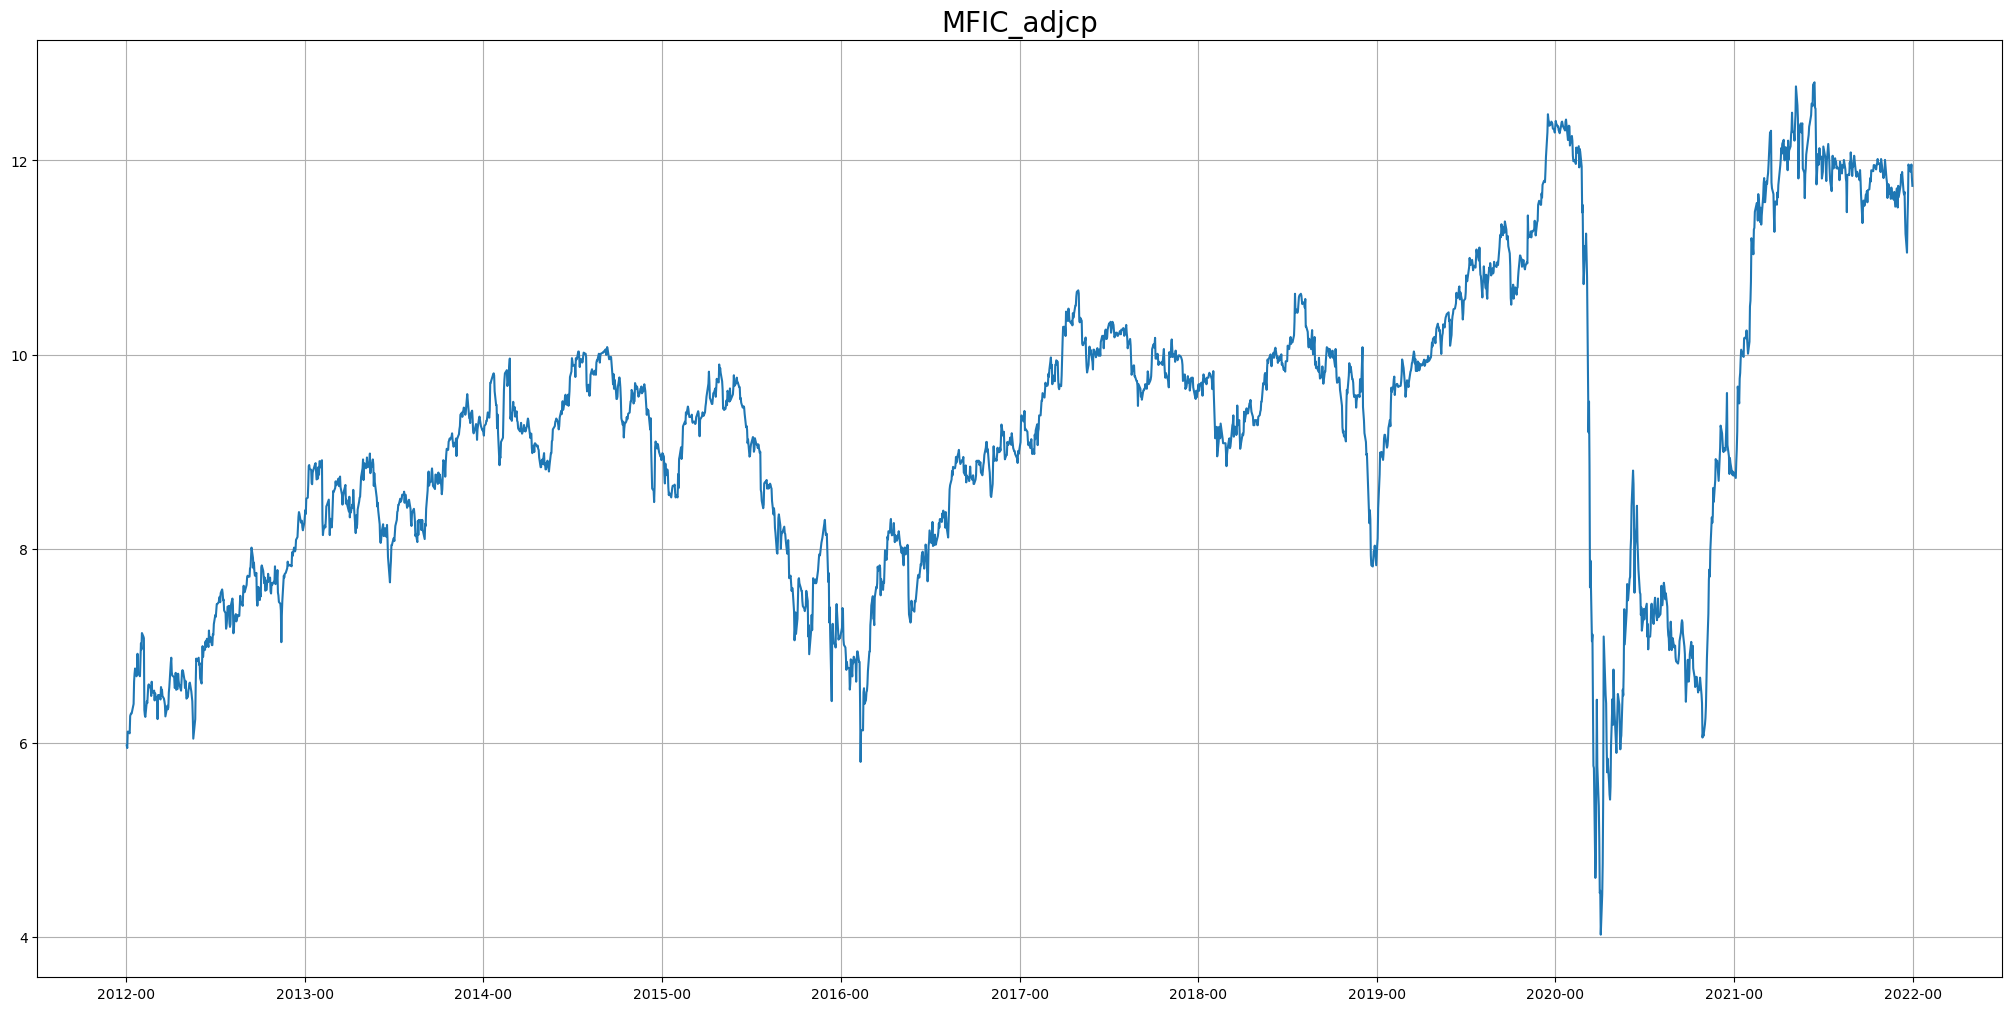

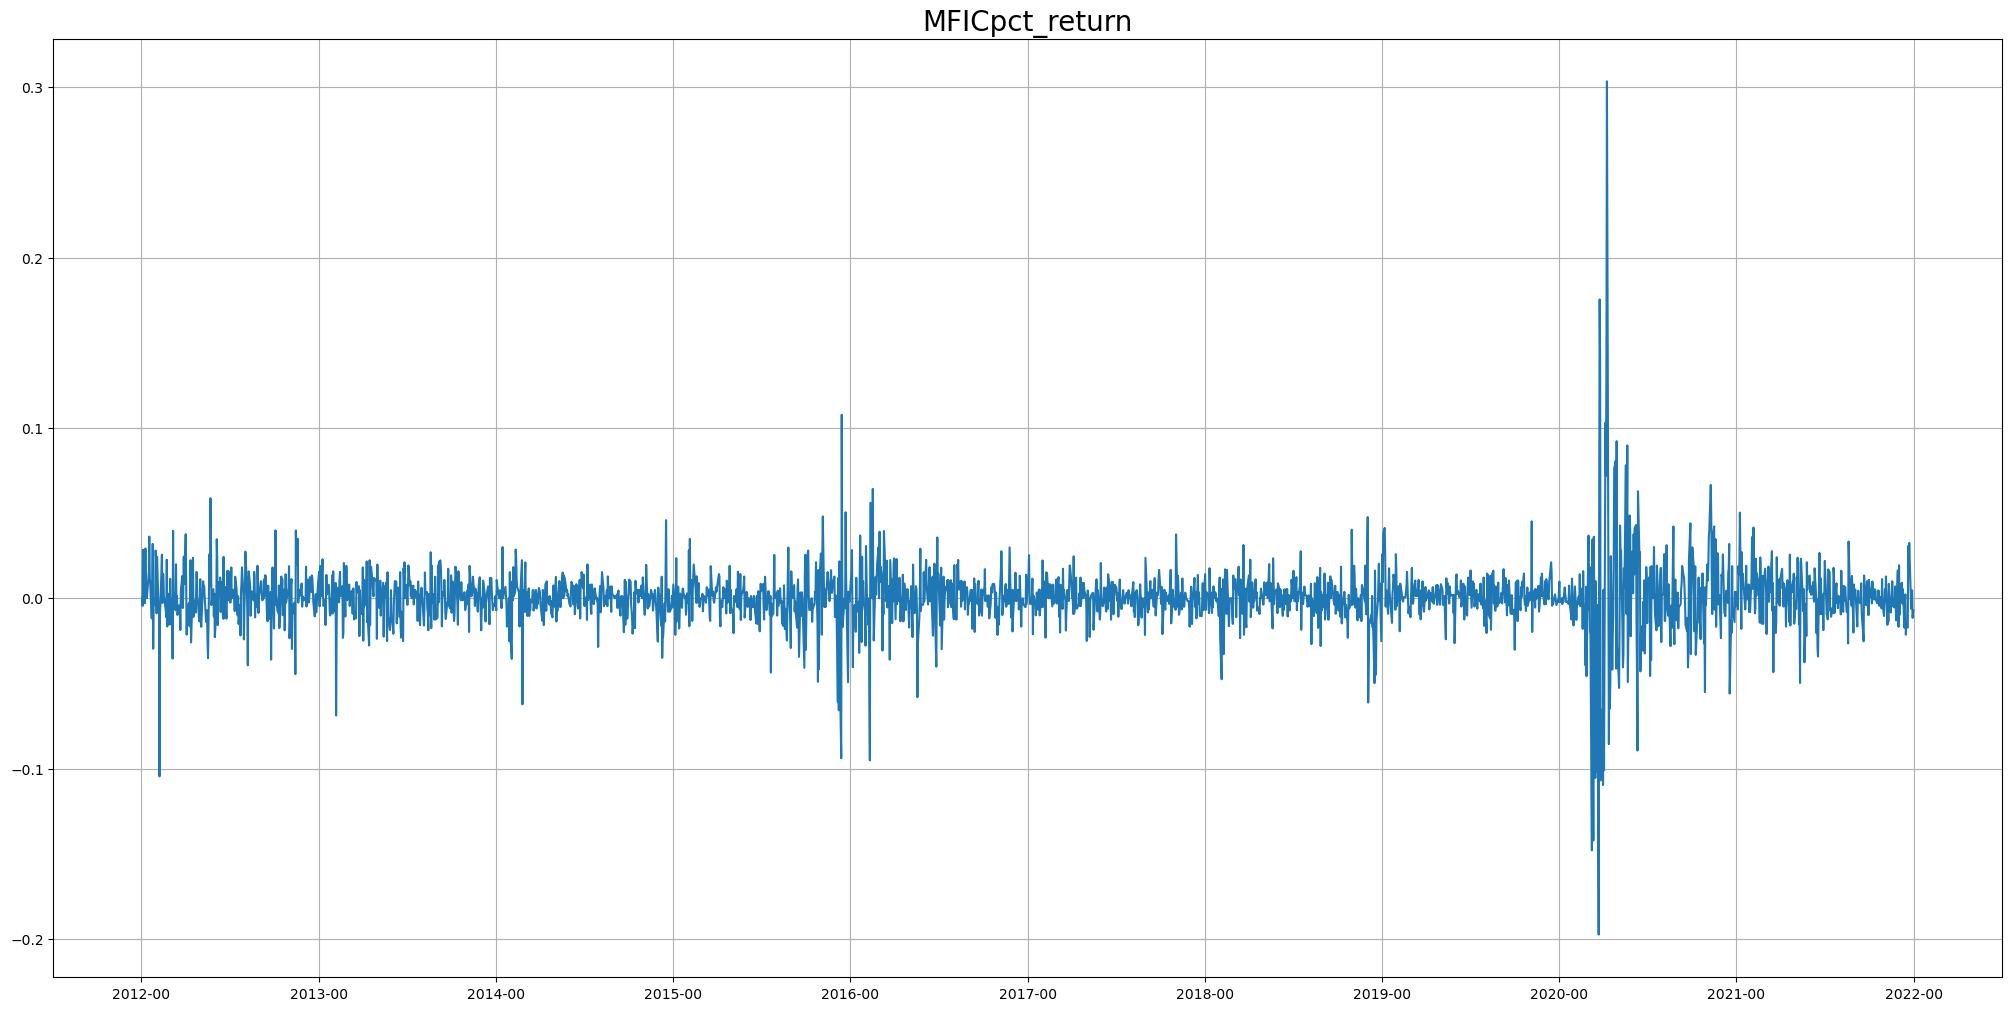

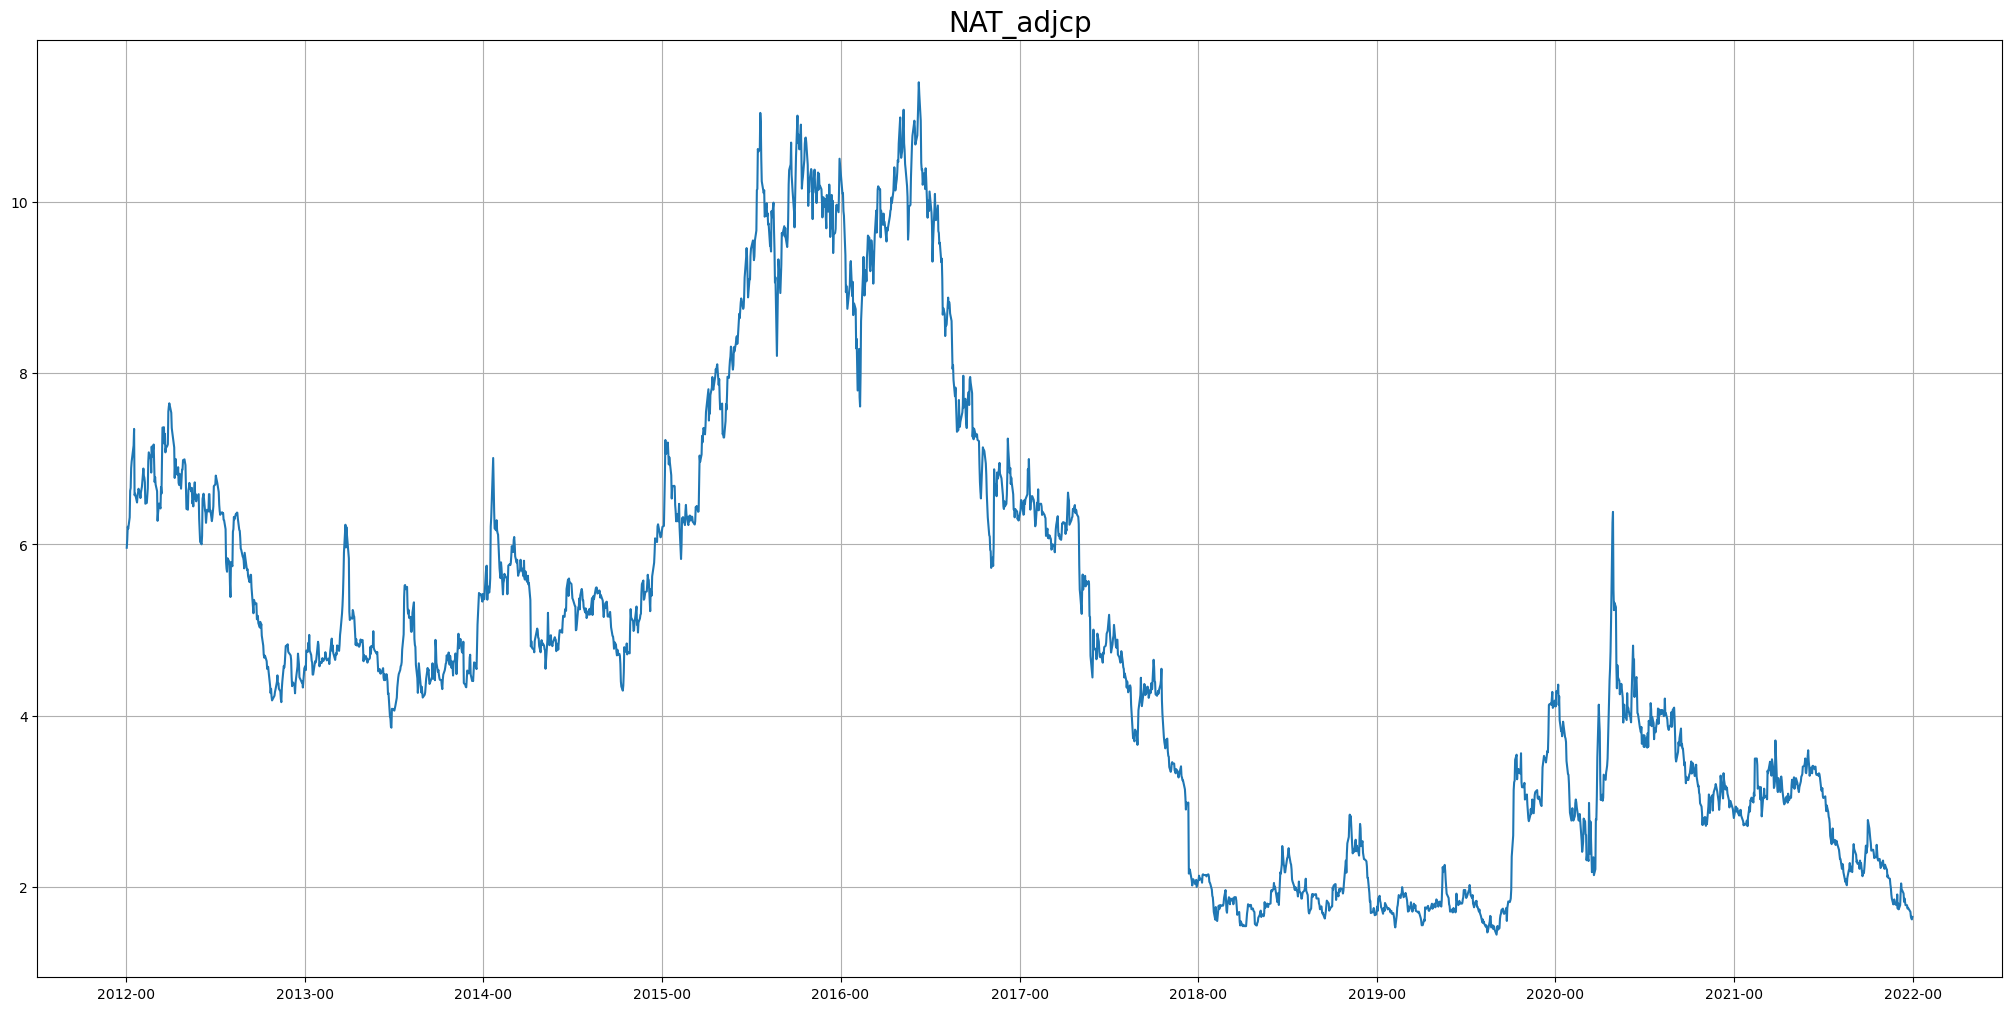

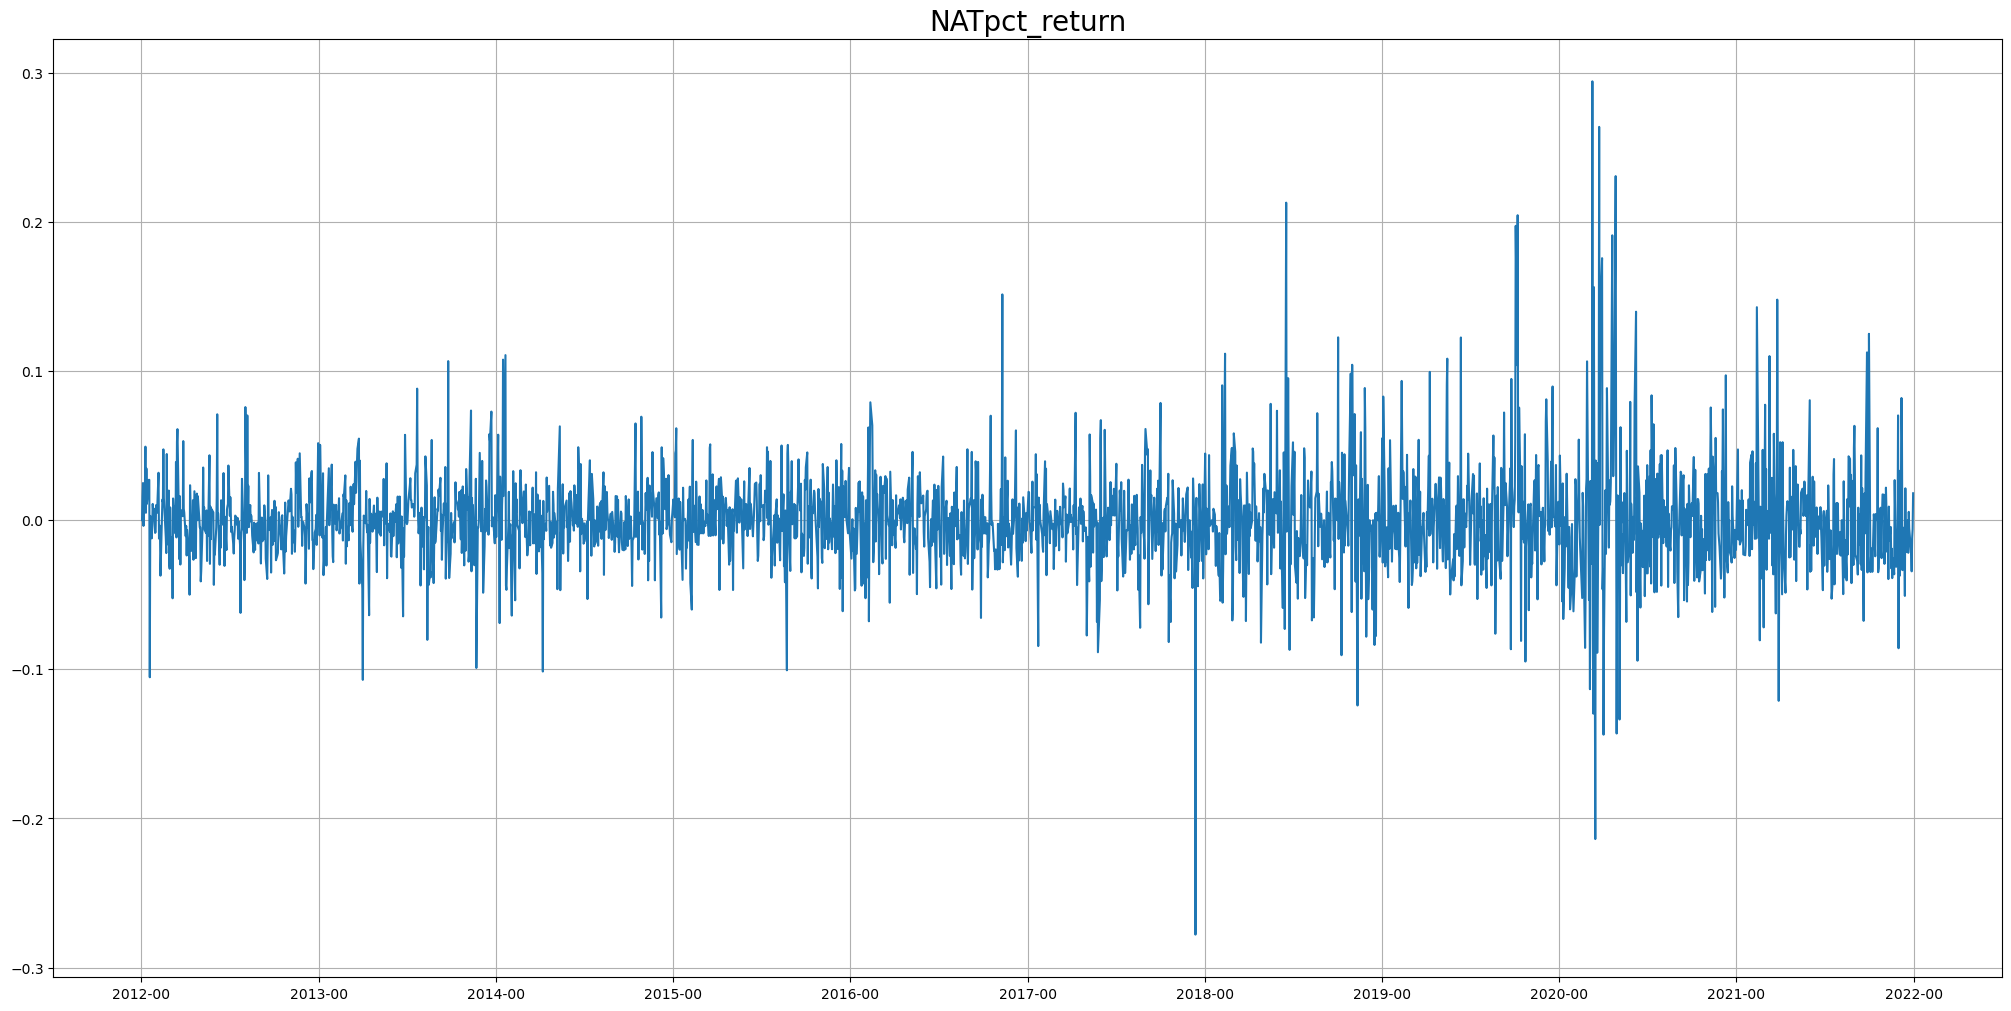

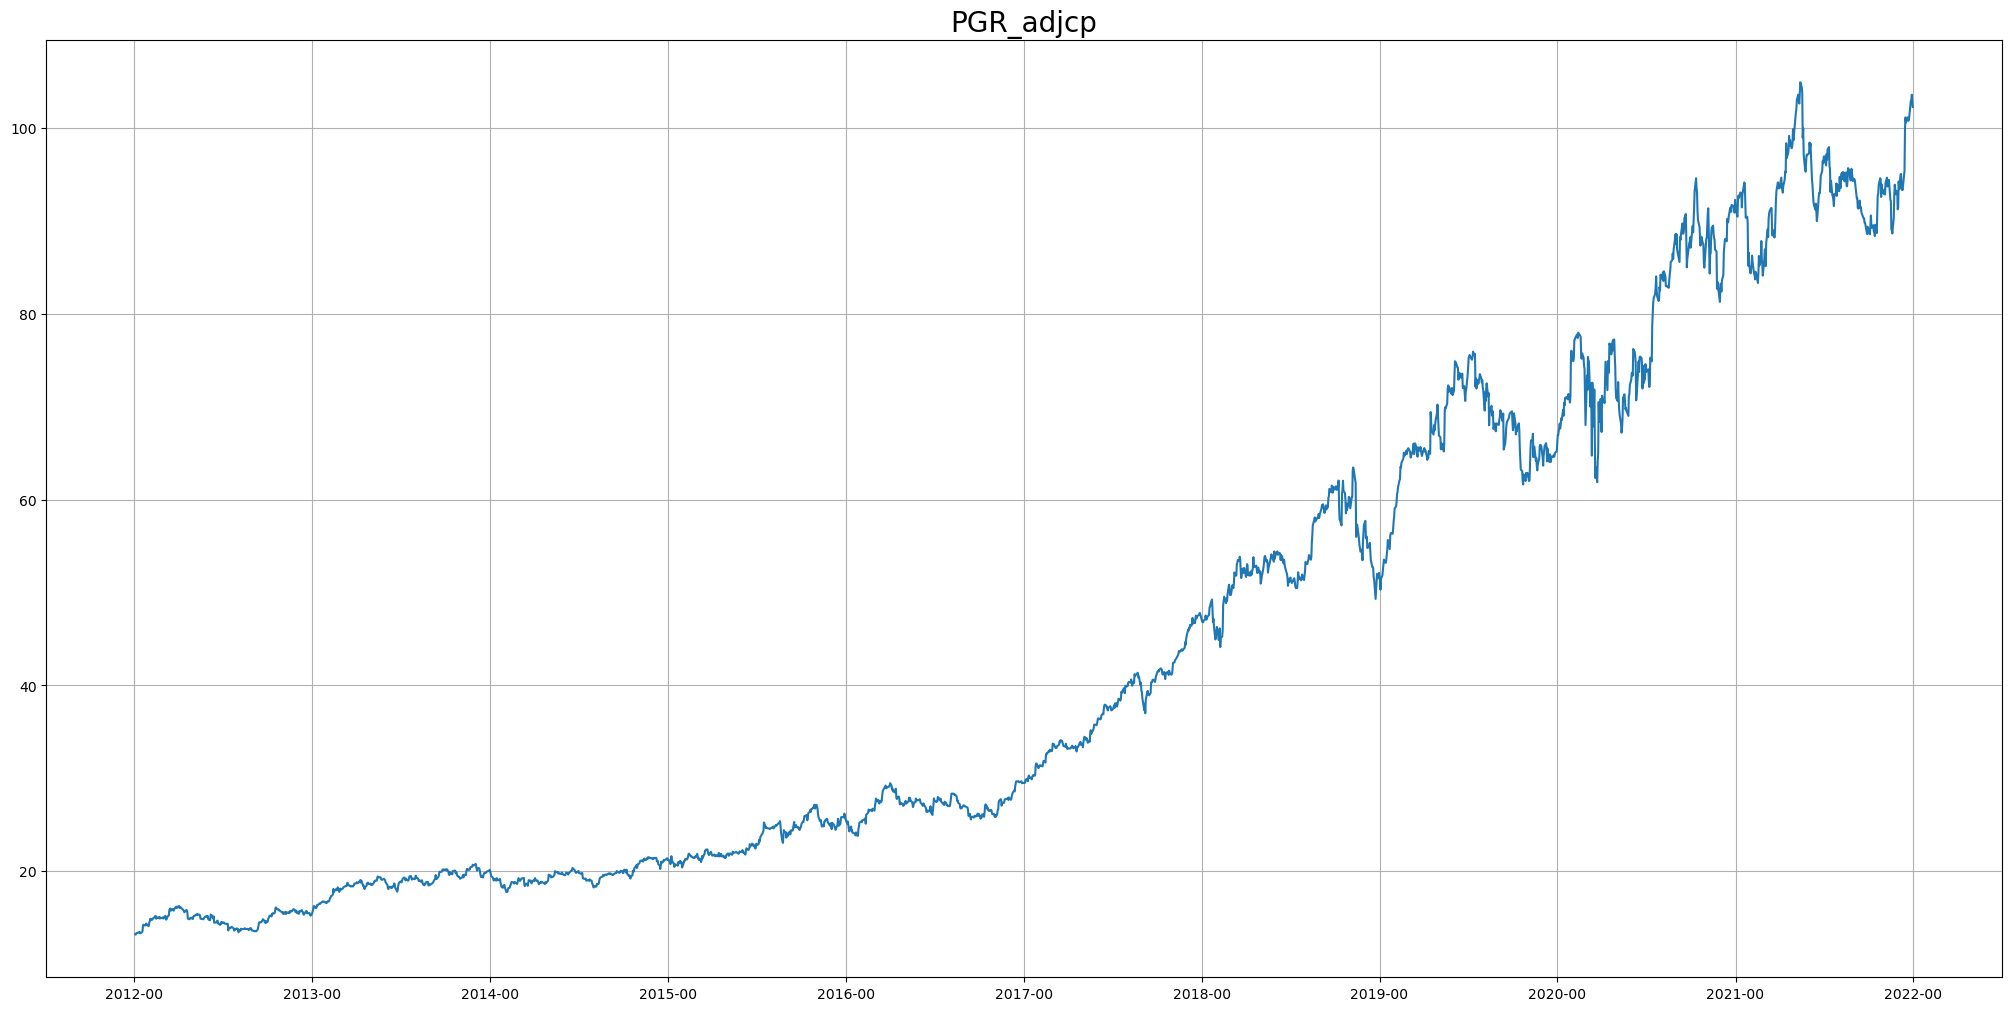

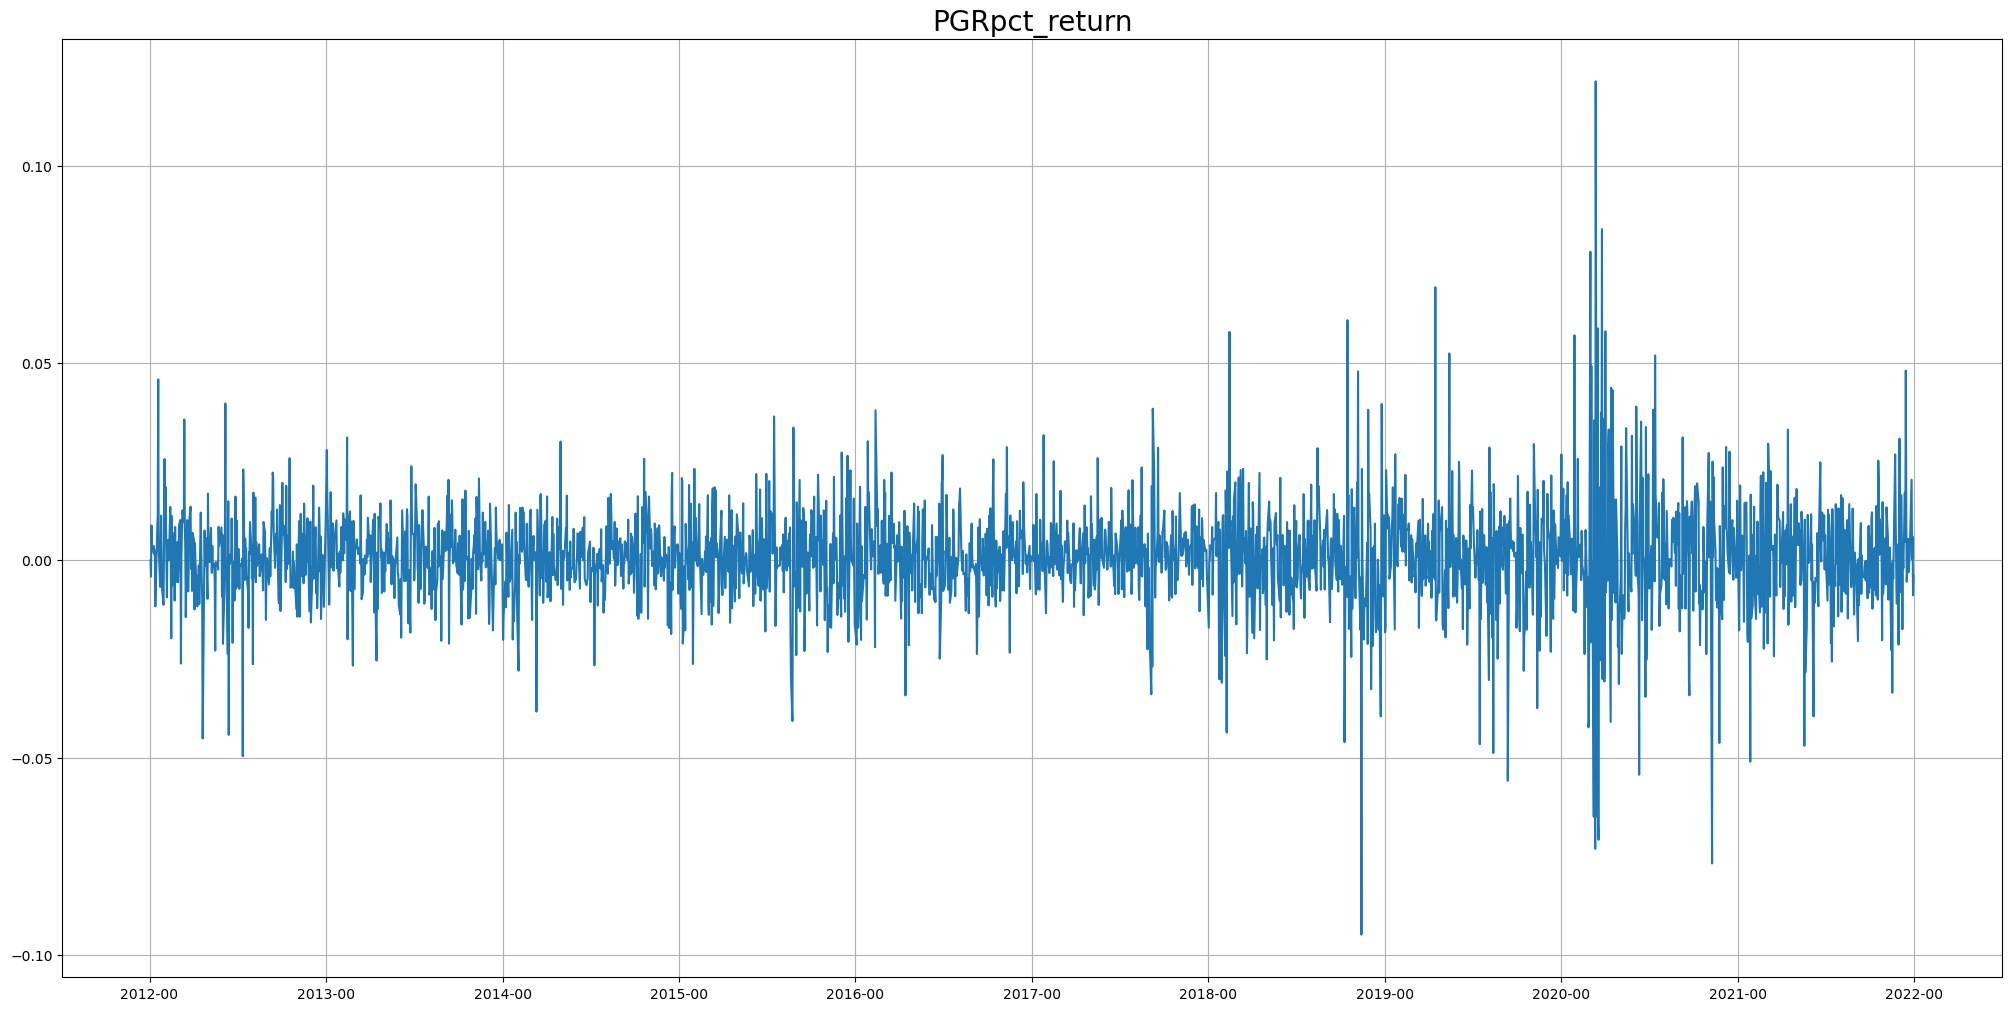

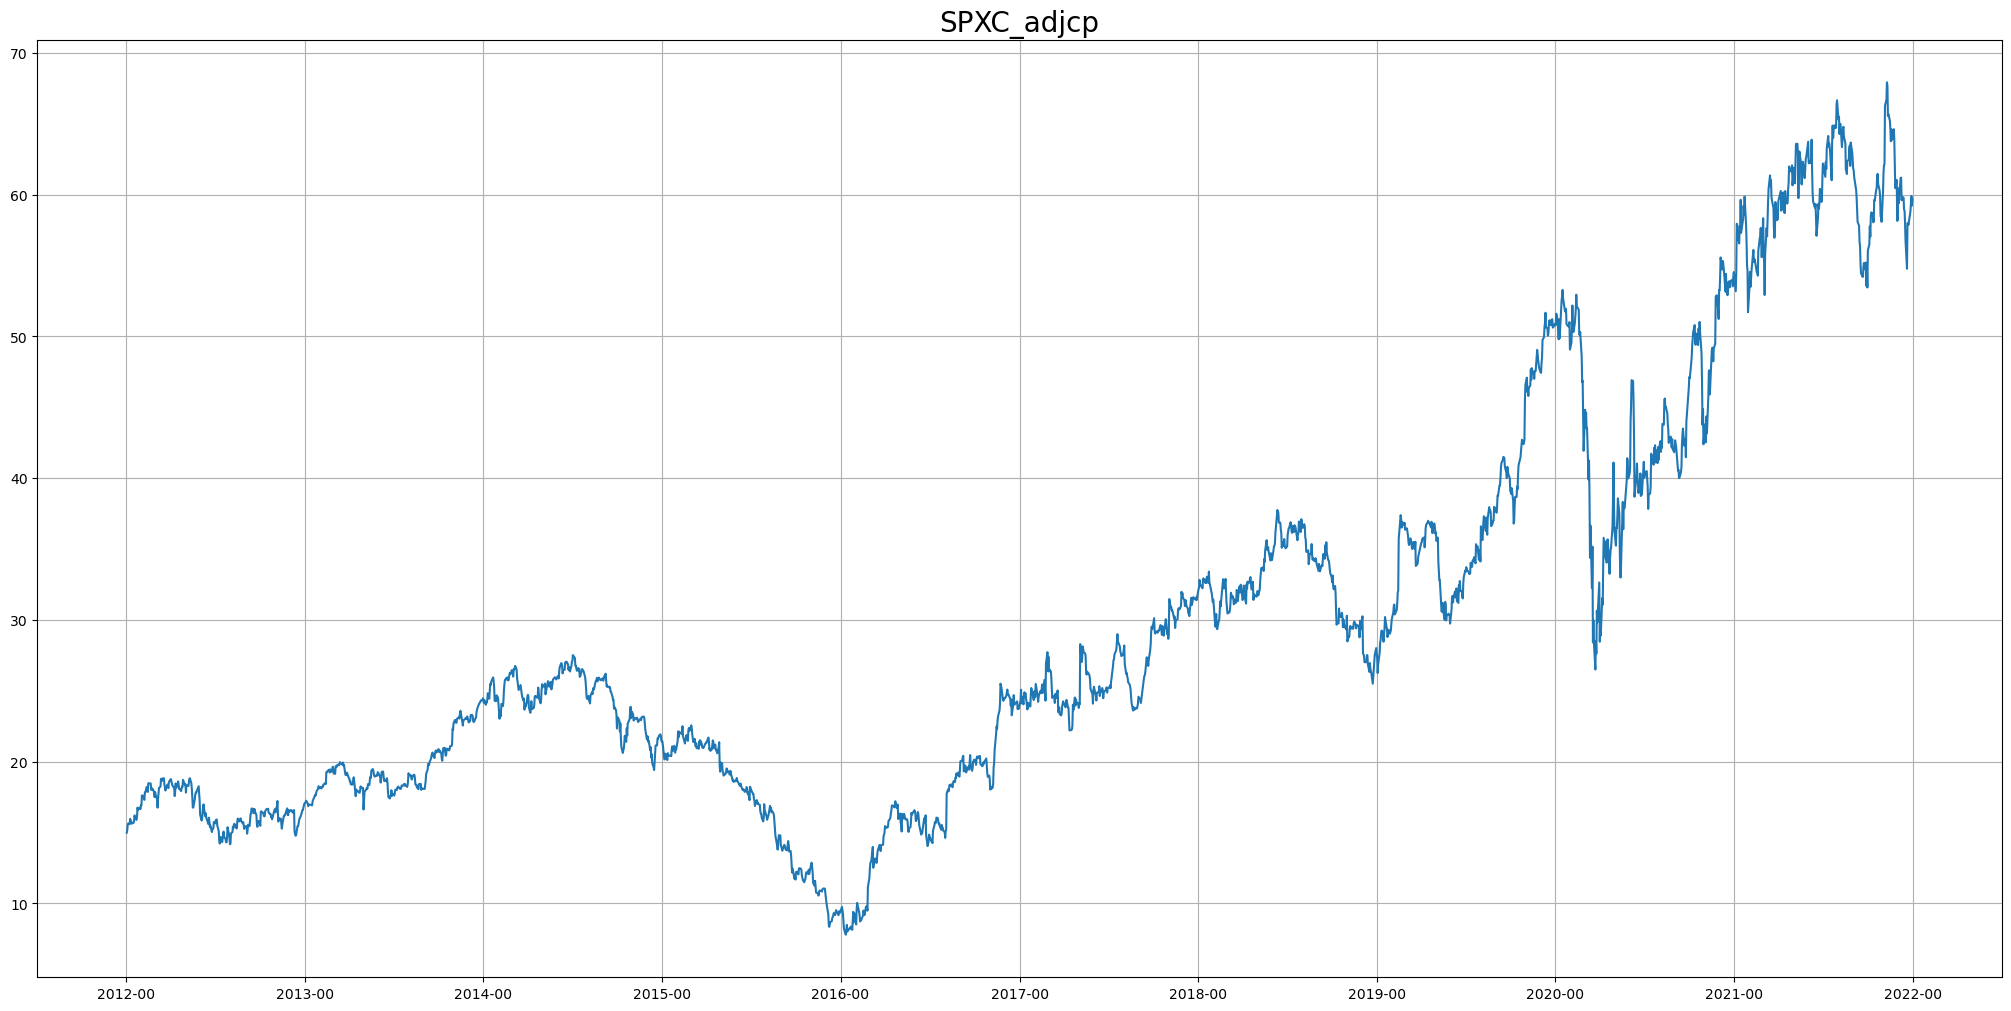

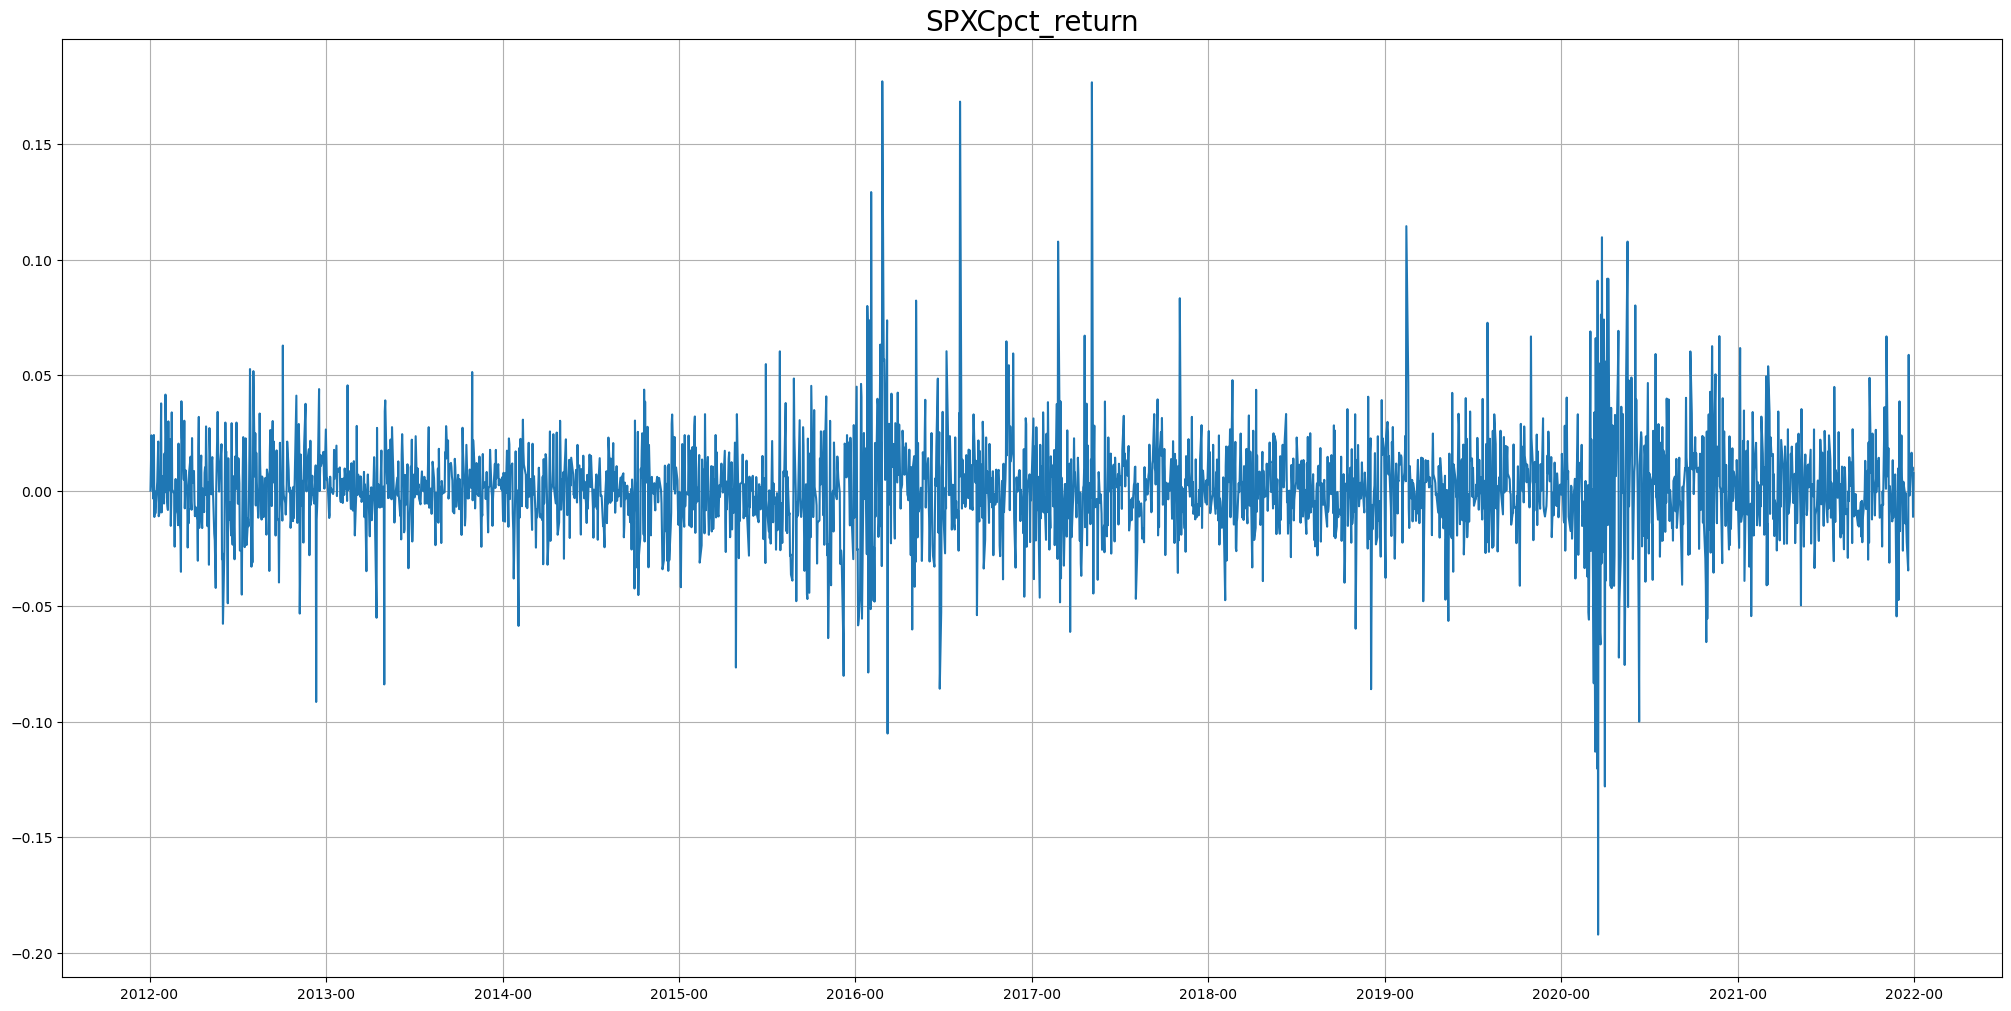

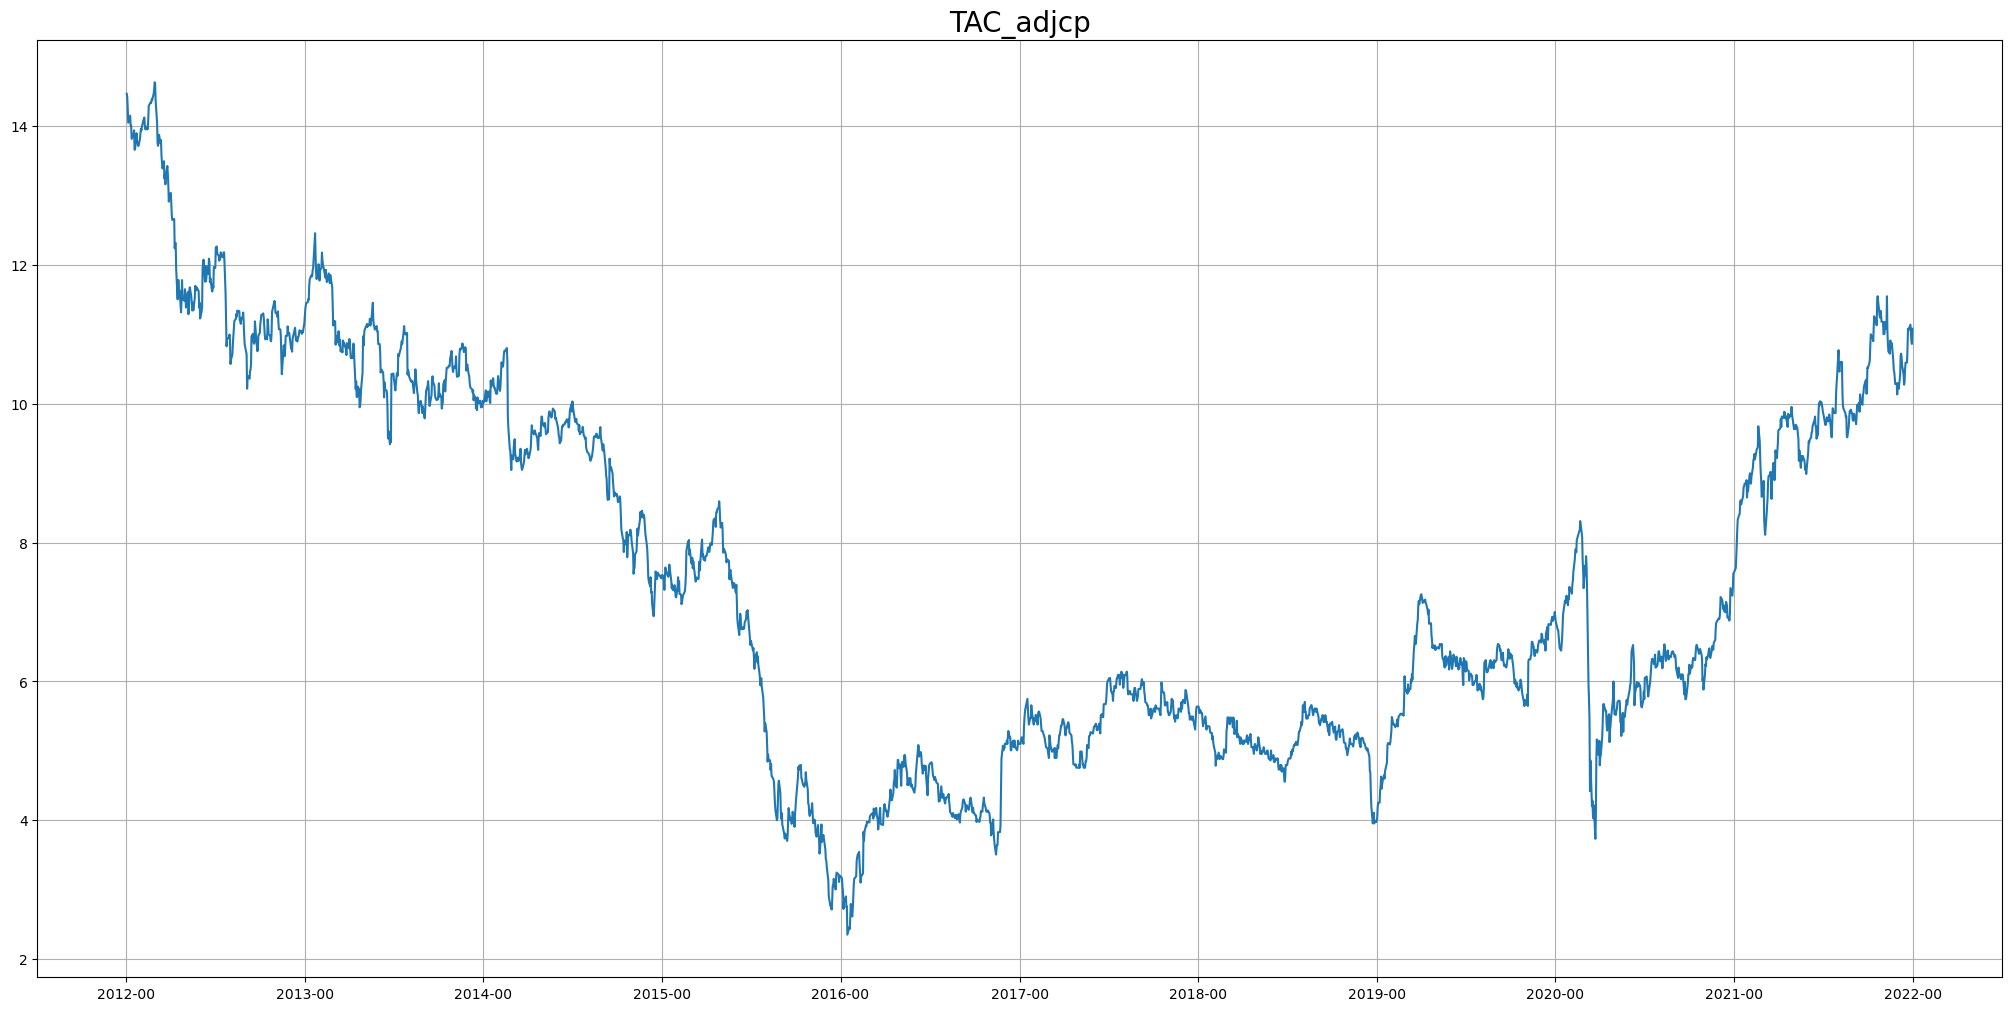

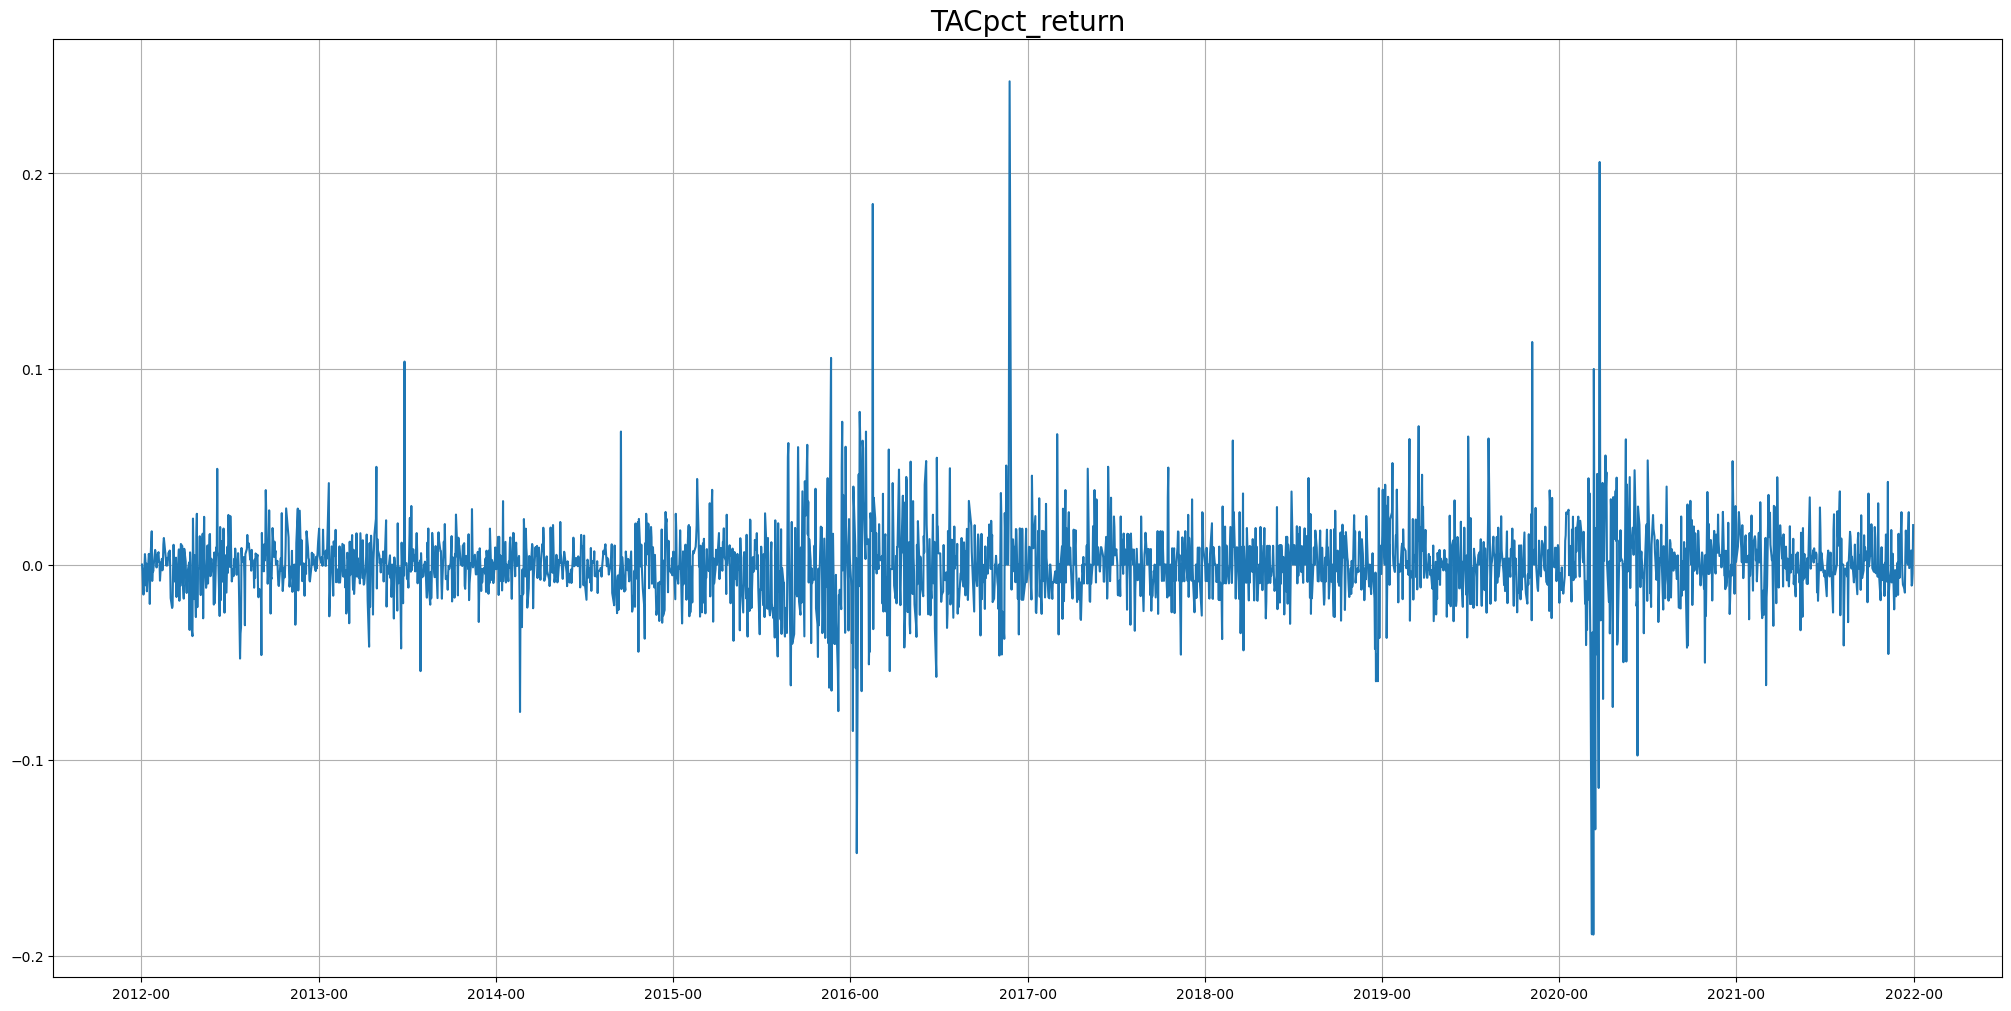

In [163]:
for i,tic in enumerate(tics):
    plot_both(data_dict[tic],tic)

# band-pass filter

In [173]:
for tic in tics:
    #It is strongly recommended to adjust the Wn based on different data. 
    #You can refer to https://en.wikipedia.org/wiki/Butterworth_filter for parameter setting 
    adjcp_apply_filter(data_dict[tic],Wn_adjcp=2/7,Wn_pct=2/14,order = 4)

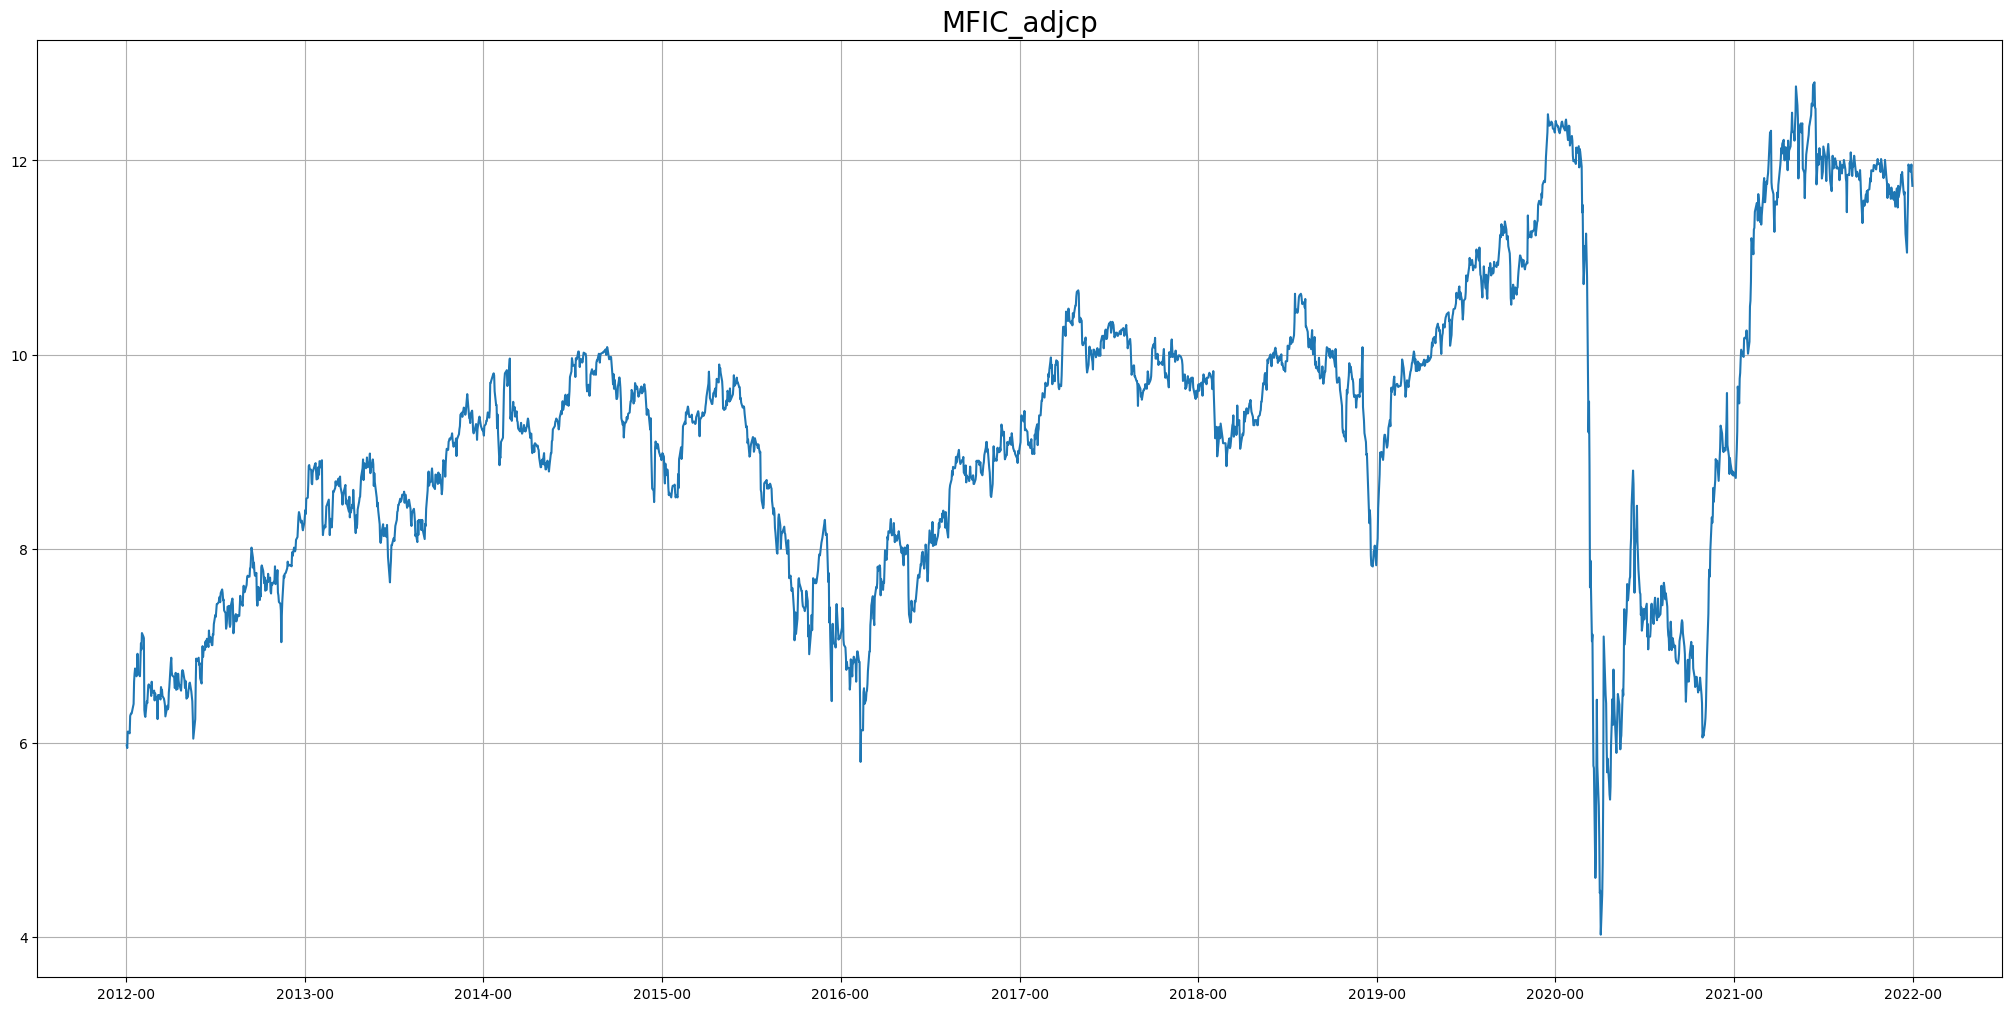

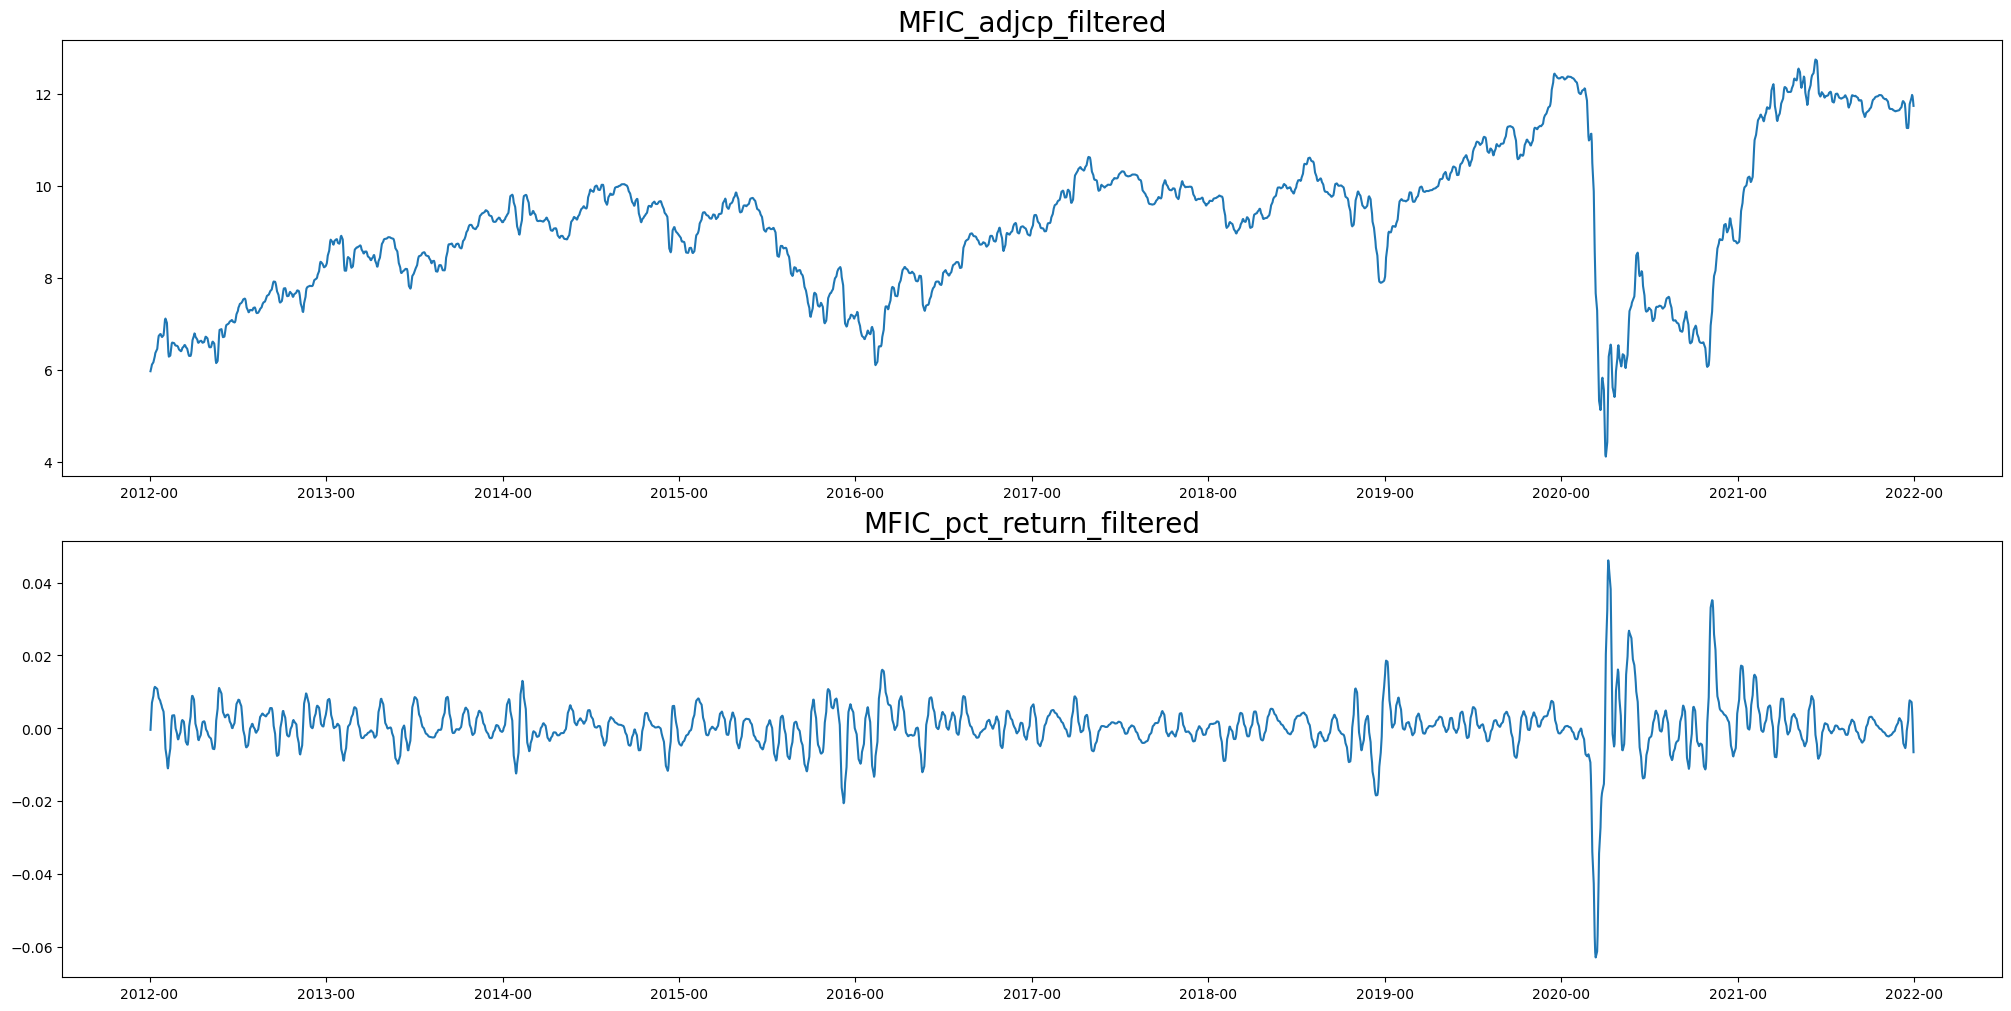

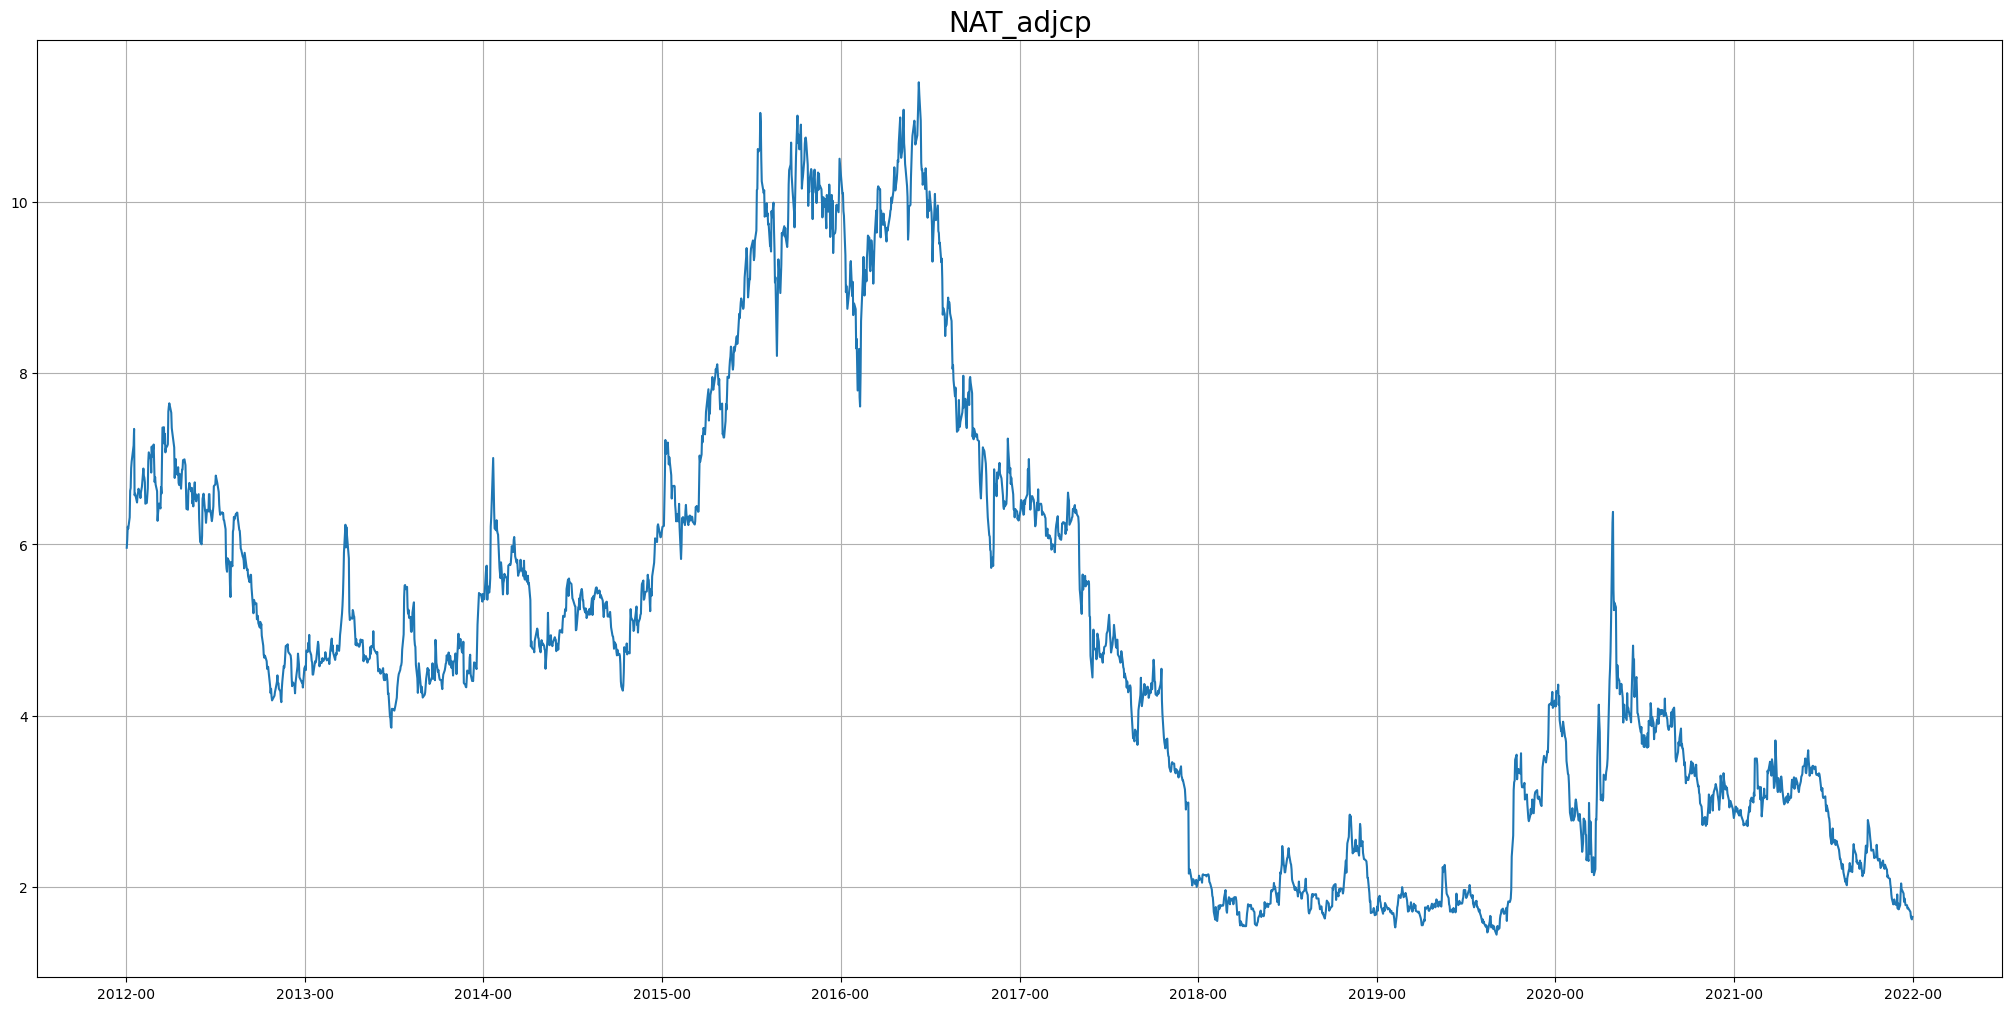

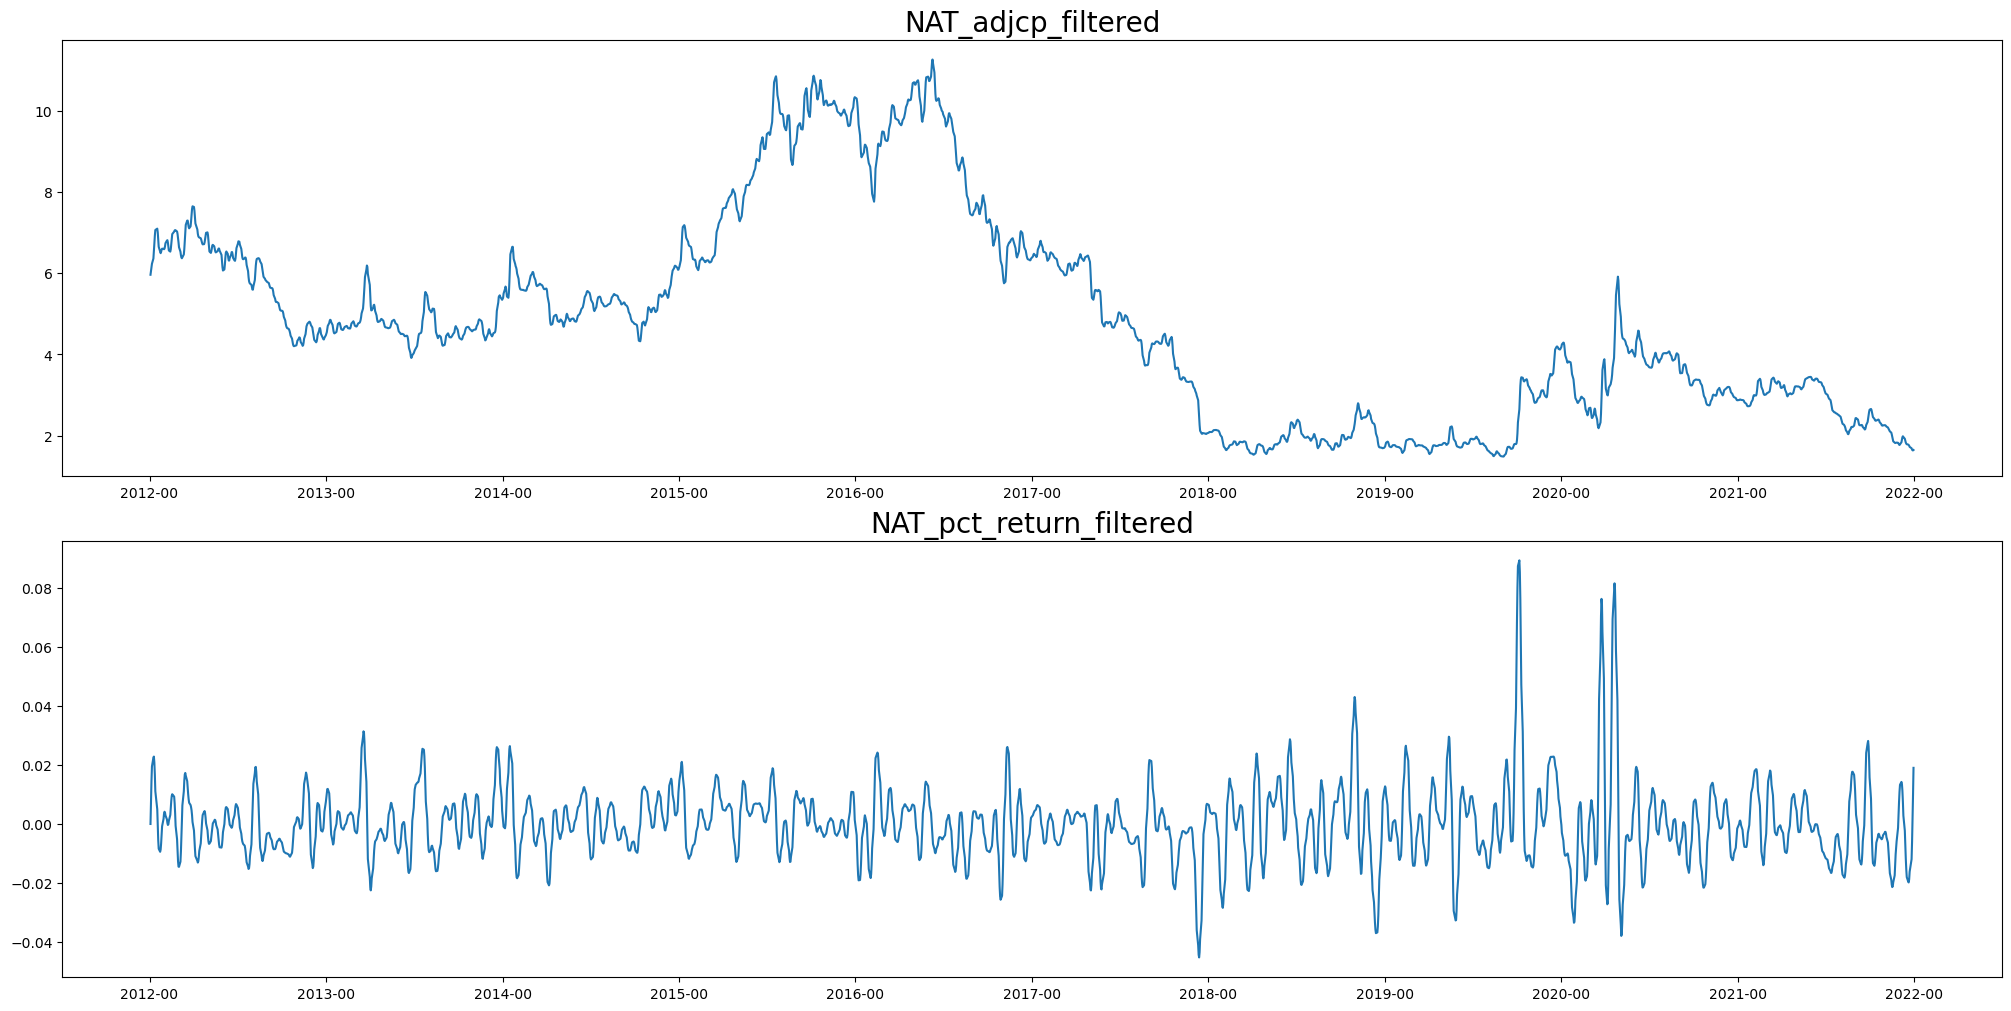

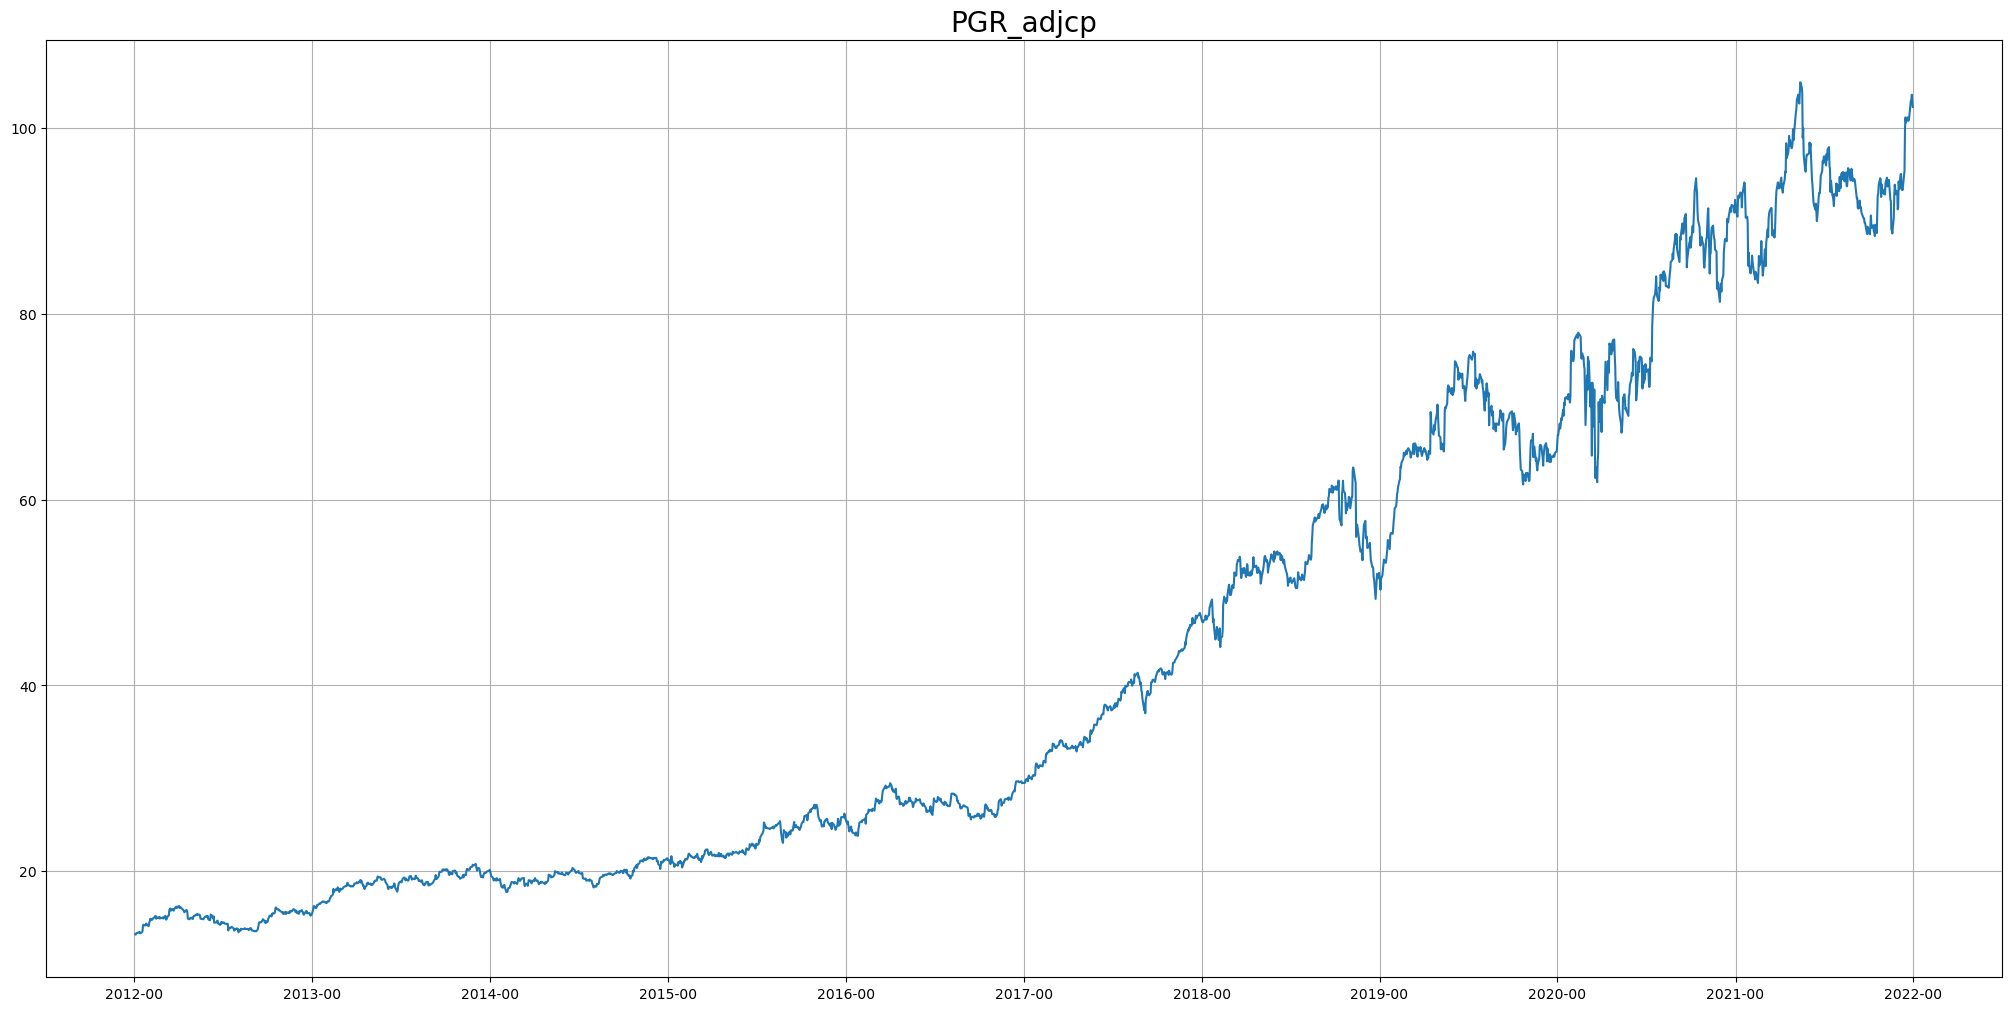

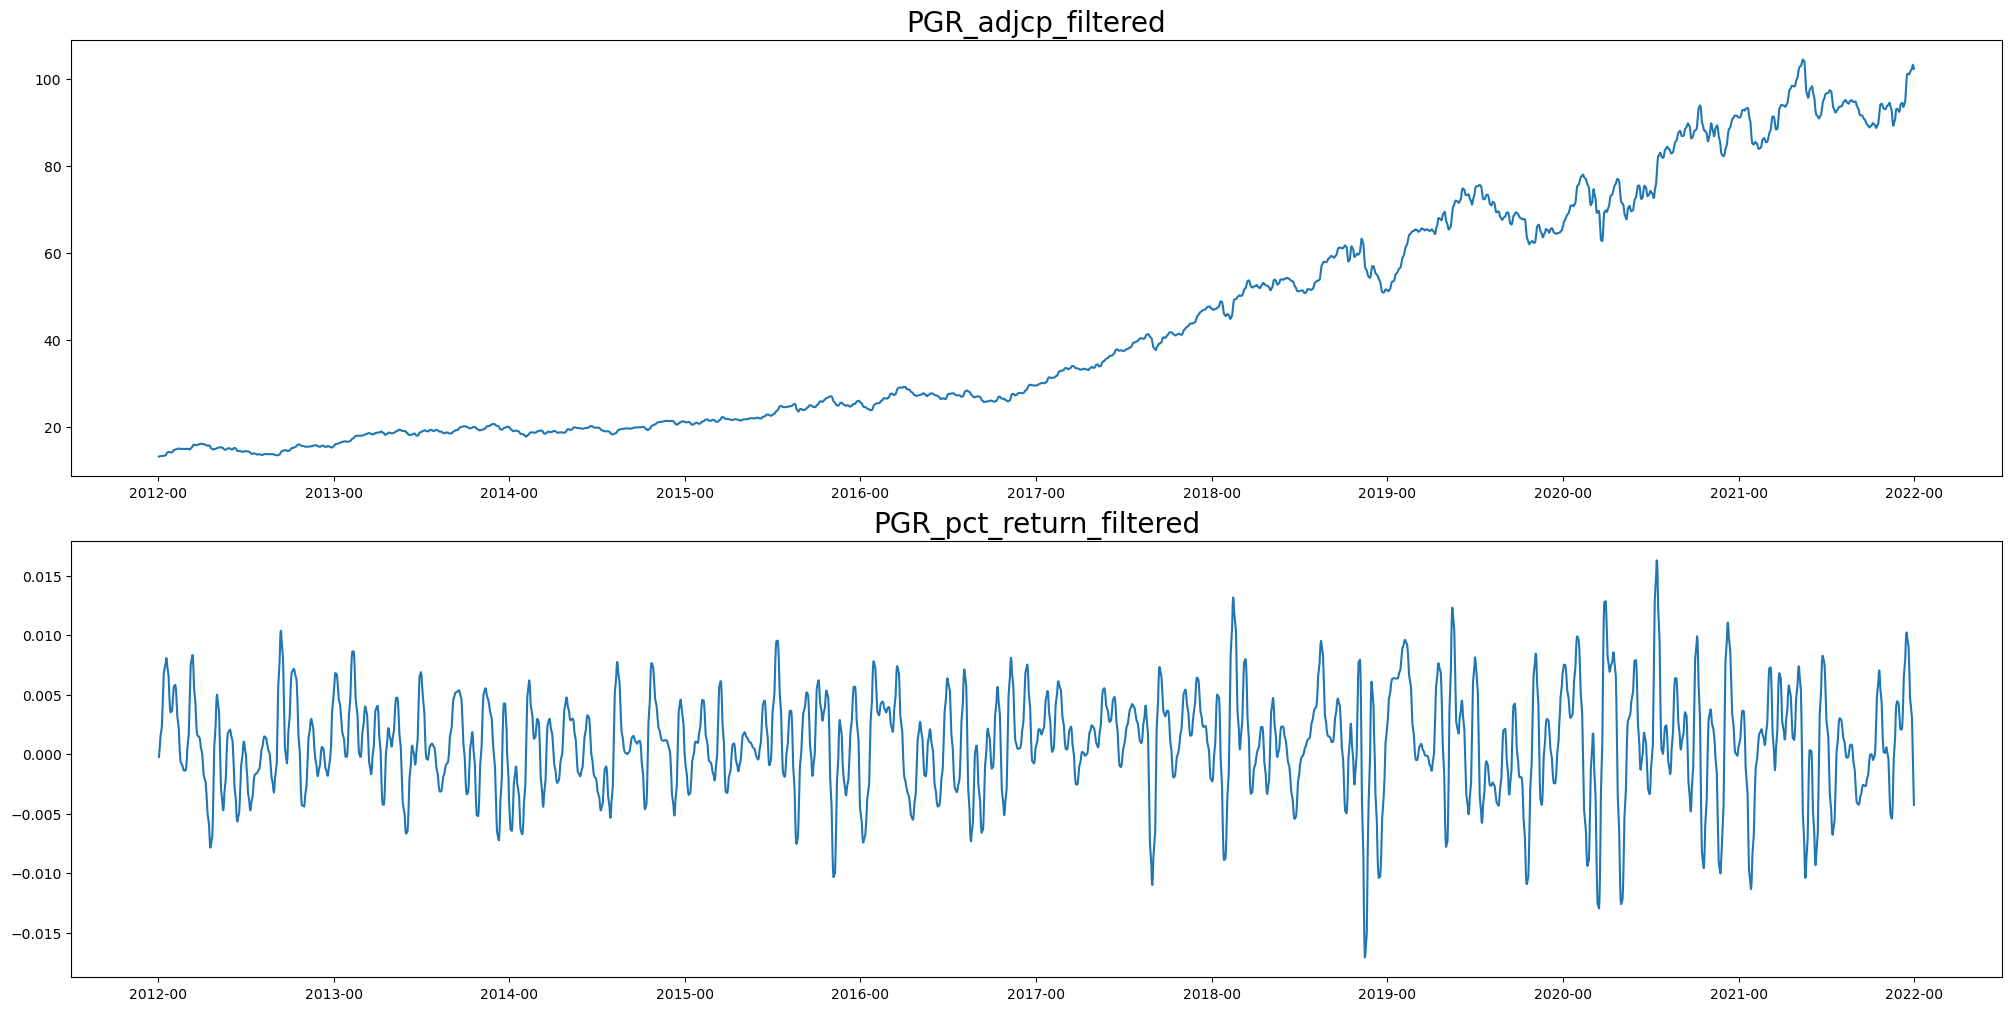

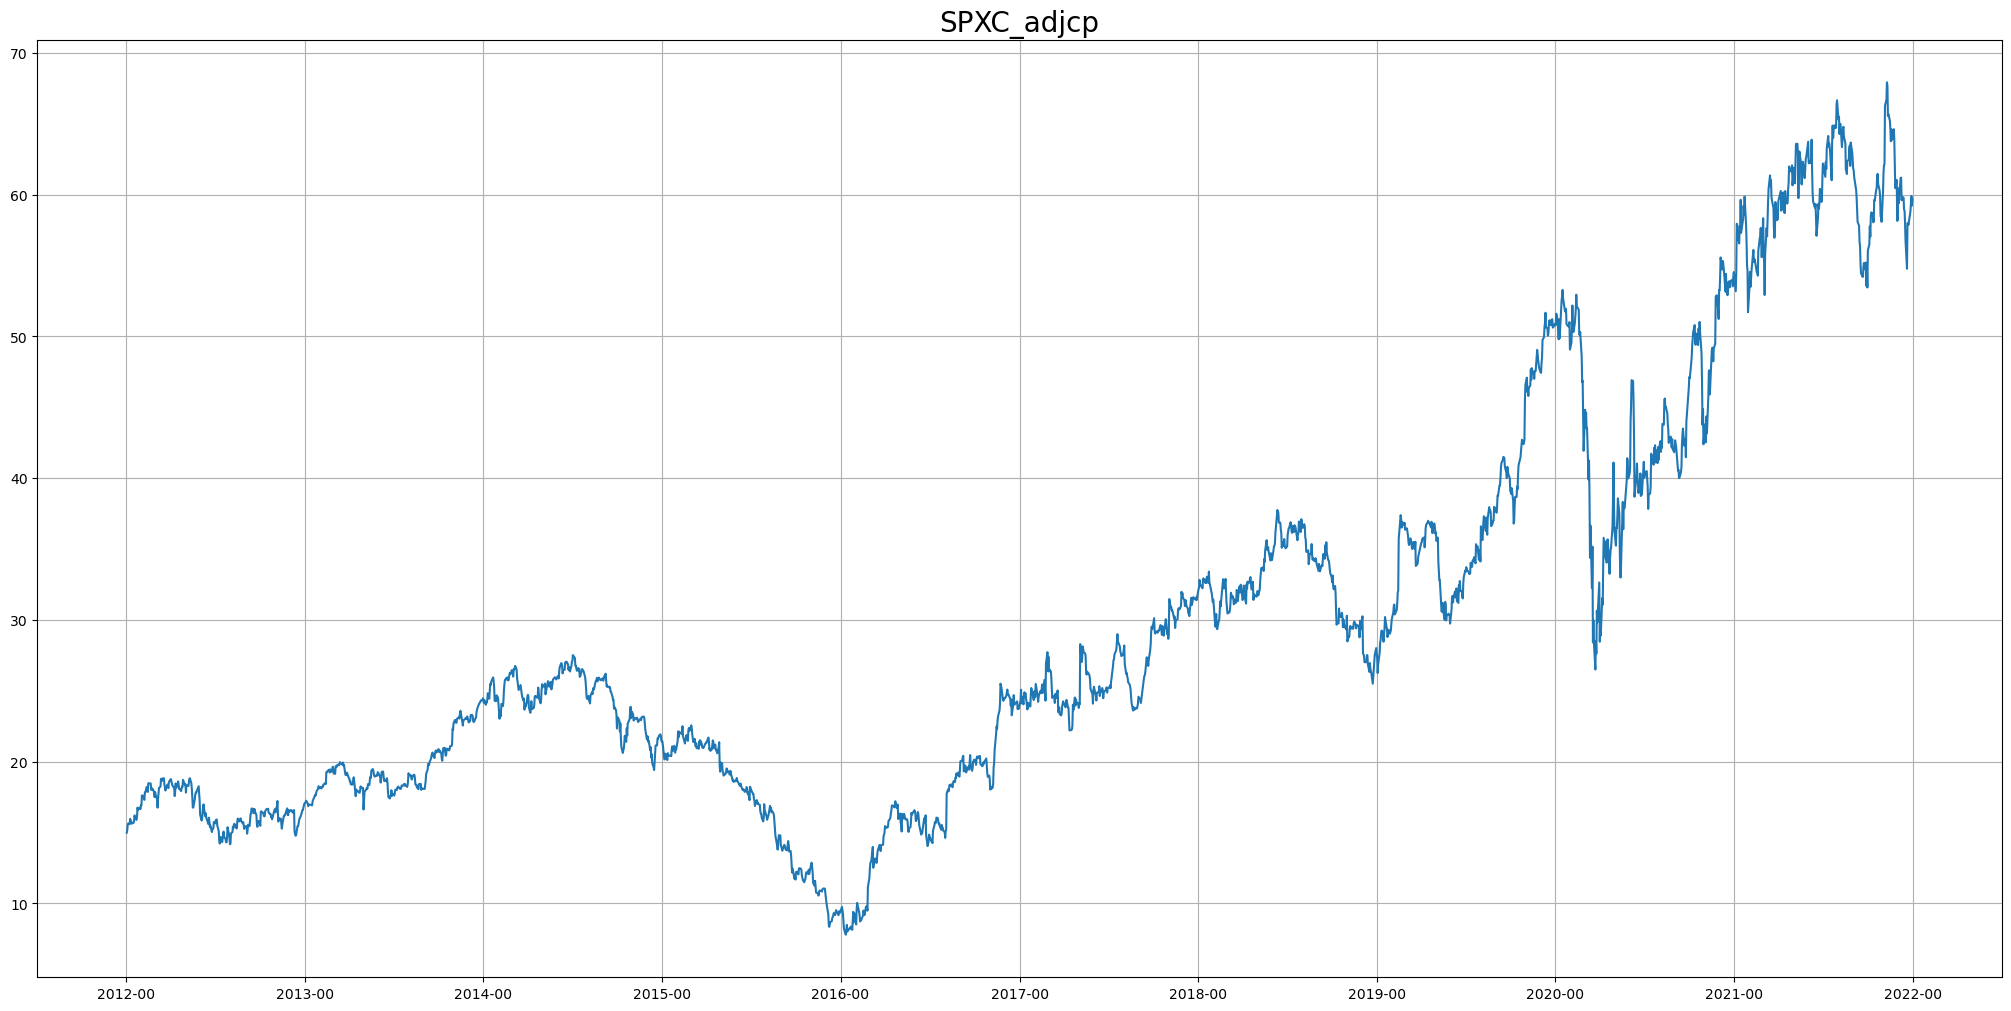

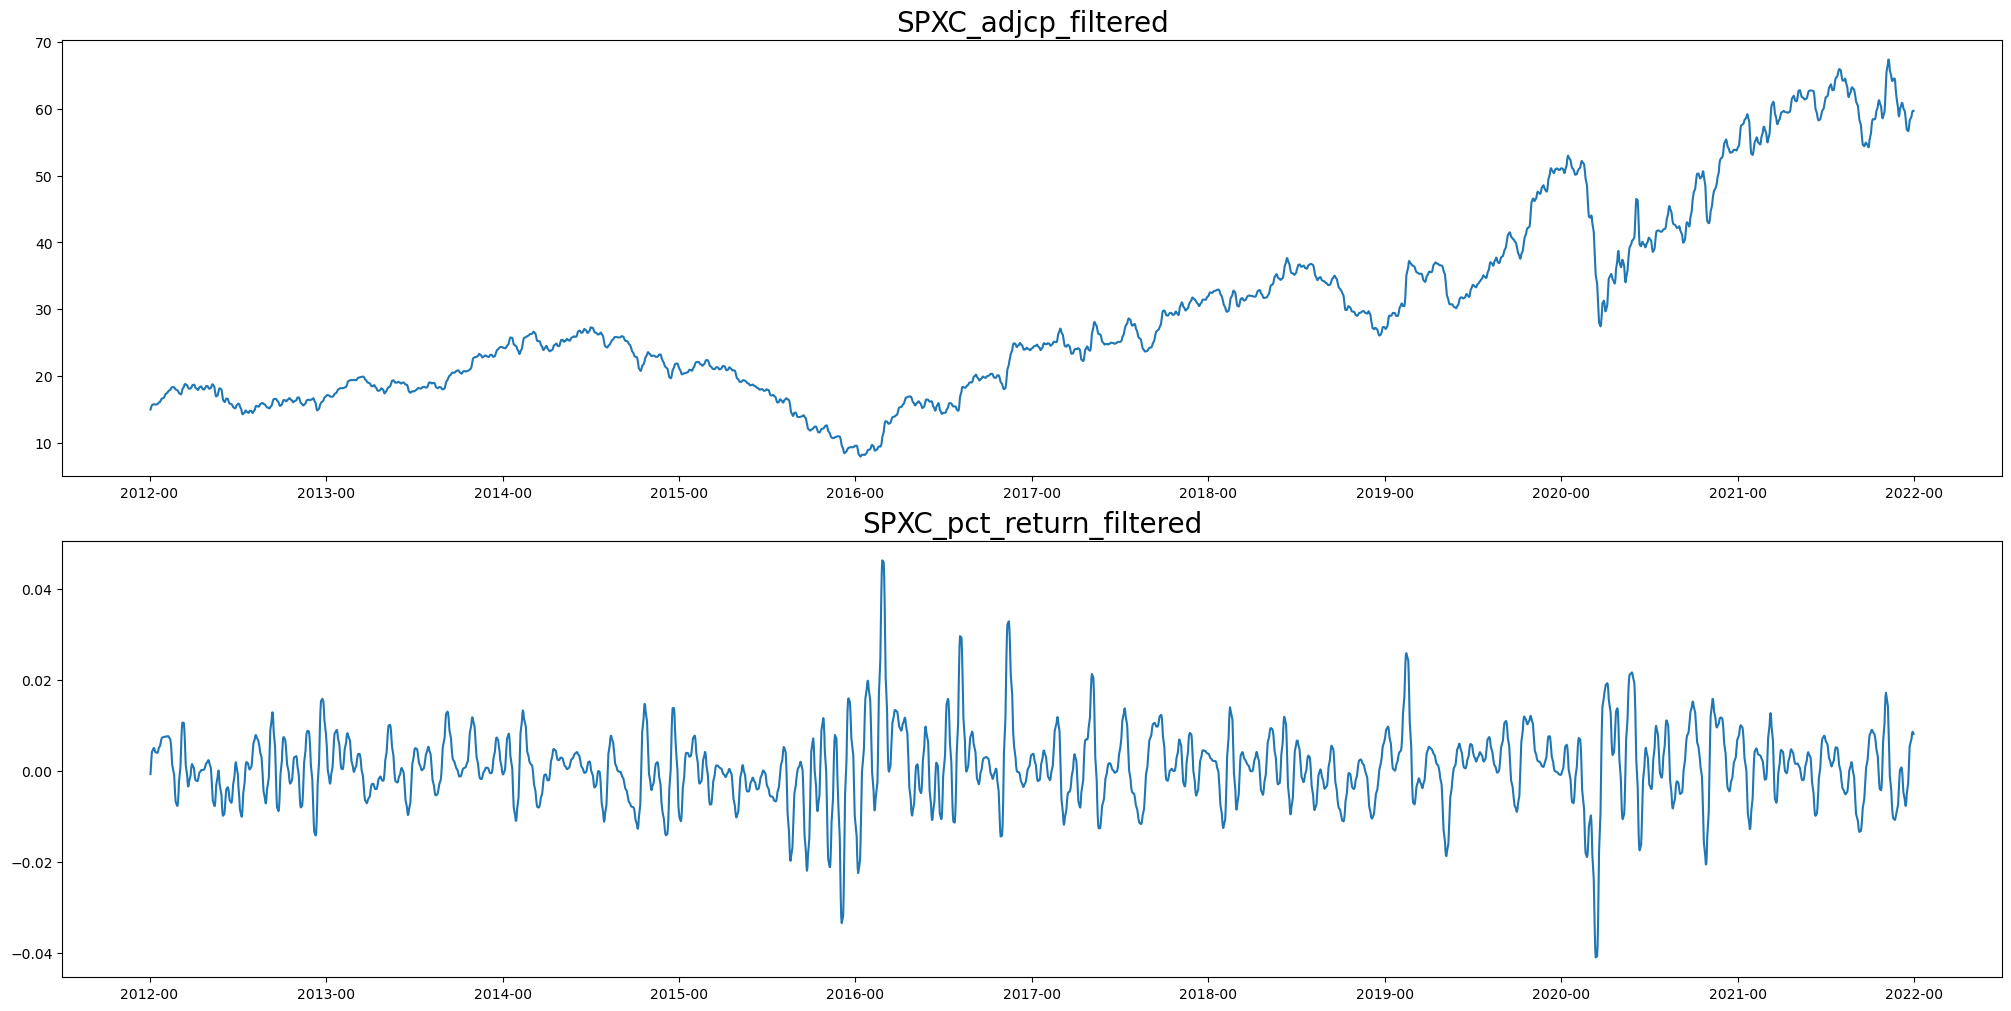

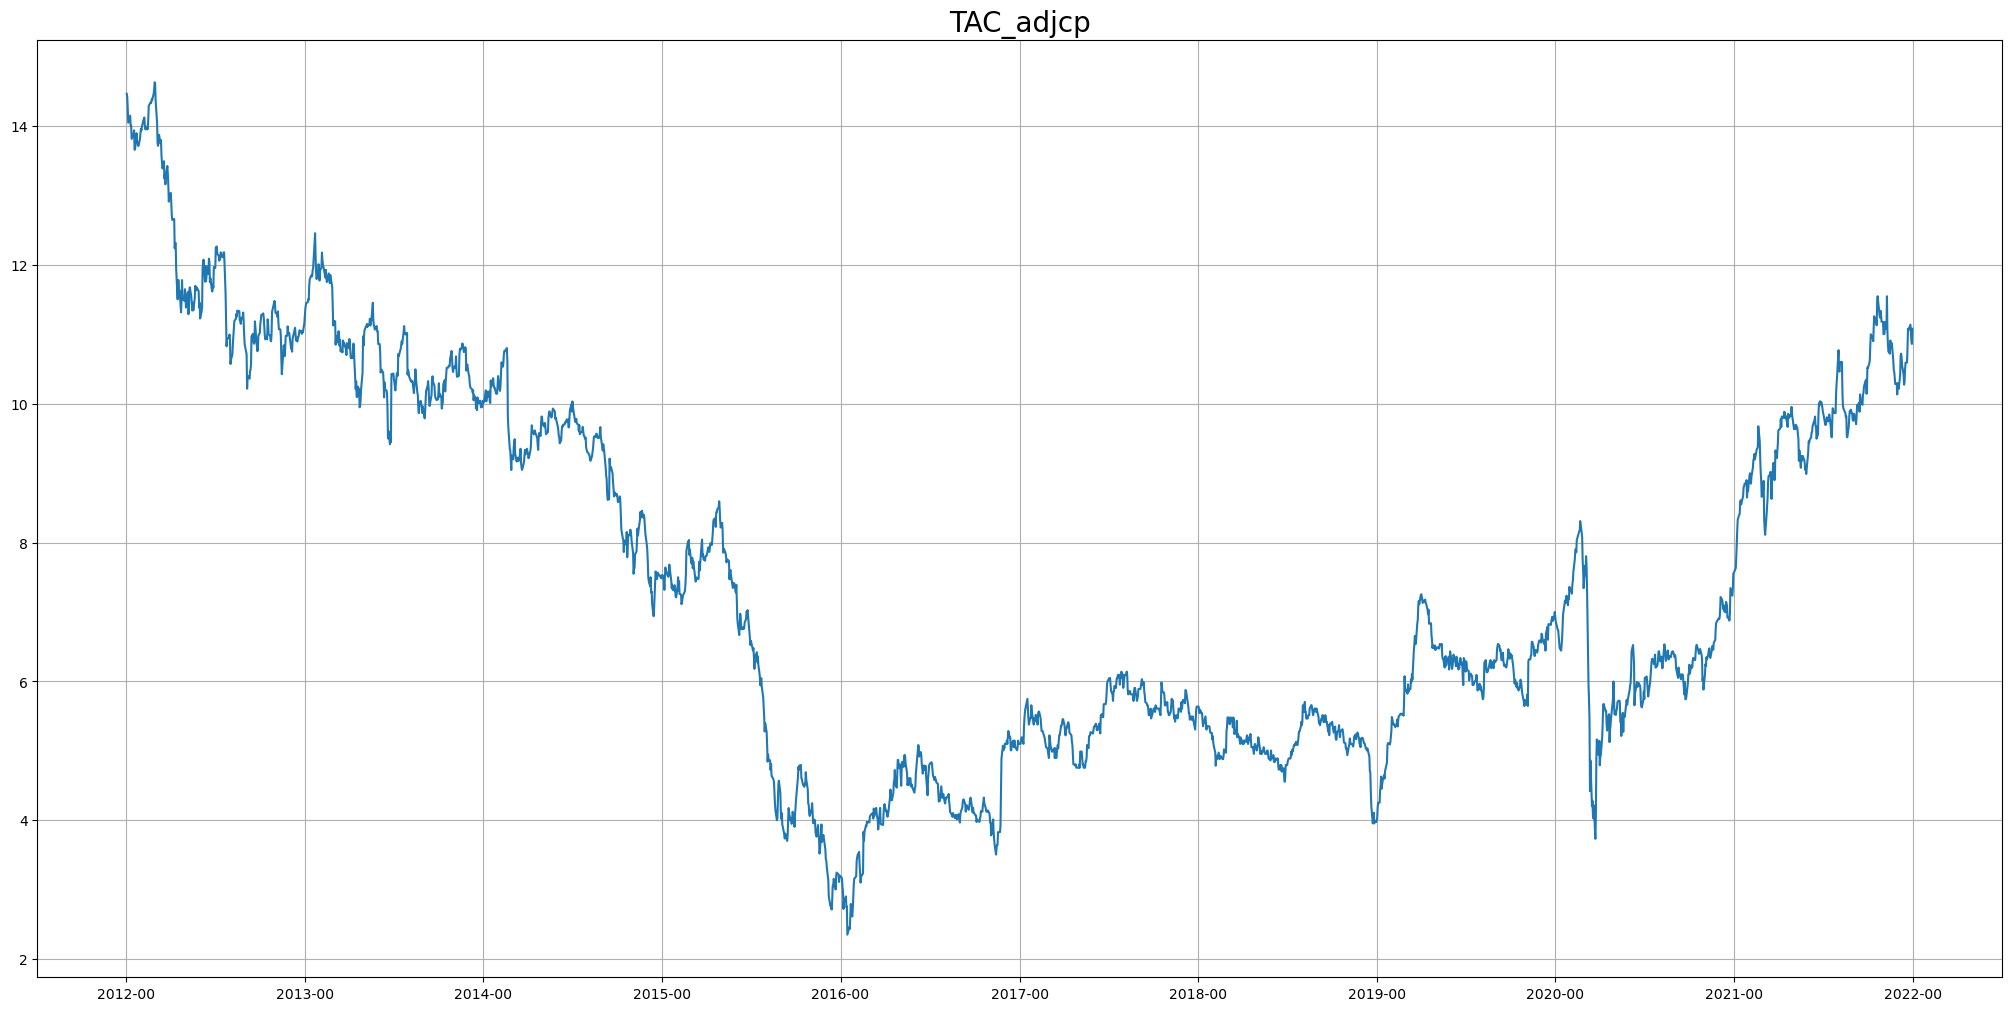

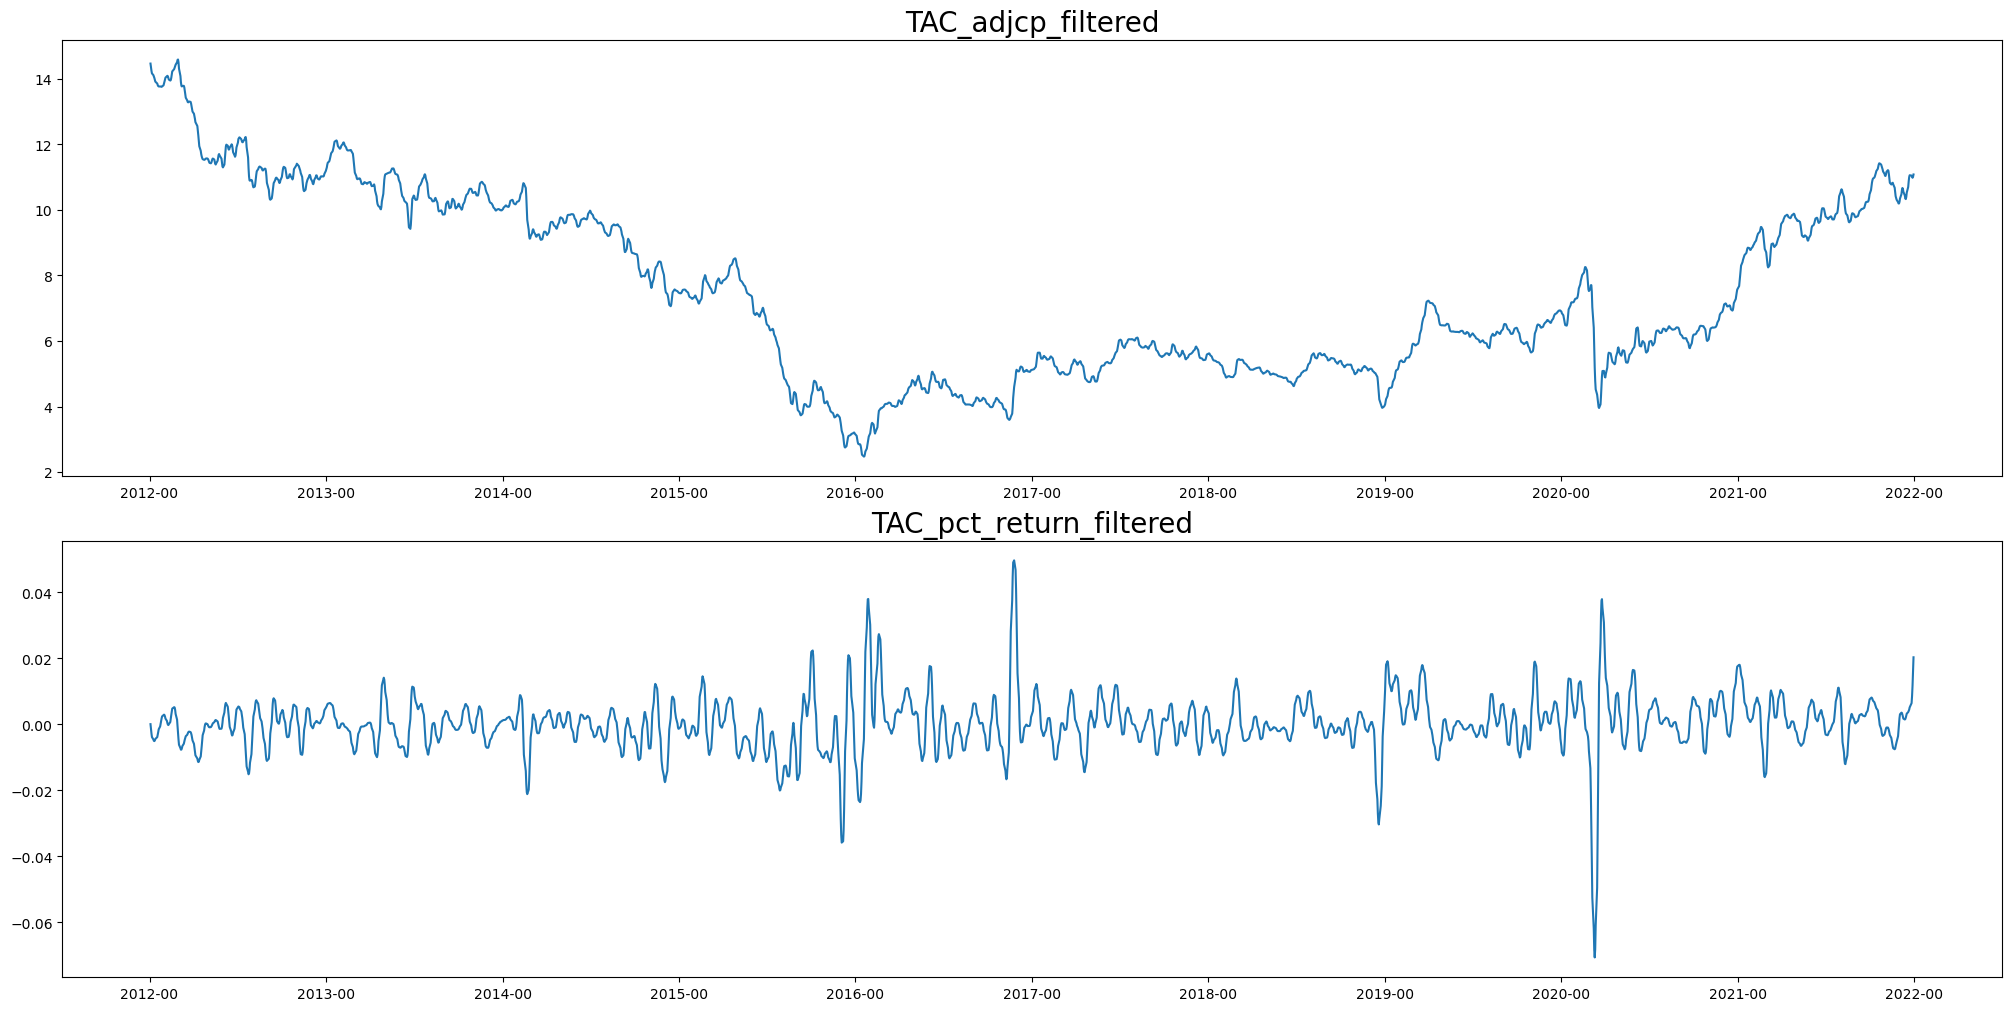

In [174]:
for tic in tics:
    plot_ori(data_dict[tic],tic)
    plot_lowpassfilter(data_dict[tic],tic,savefig=False)

# linear model 

In [177]:
turning_points_dict={}
coef_list_dict={}
norm_coef_list_dict={}
y_pred_dict={}

In [183]:
for i,tic in enumerate(tics):
    coef_list,turning_points,y_pred_list,norm_coef_list=linear_regession_turning_points(data_ori=data_dict[tic],tic=tic)
    turning_points_dict[tic]=turning_points
    coef_list_dict[tic]=coef_list
    y_pred_dict[tic]=y_pred_list
    norm_coef_list_dict[tic]=norm_coef_list

In [184]:
all_coef_list=np.vstack([array for array in norm_coef_list_dict.values()])

In [185]:
all_coef_list.shape

(997, 1)

In [186]:
coef_stats=pd.DataFrame(all_coef_list).describe()
display(coef_stats)
percent_25=coef_stats.loc['25%',0]
percent_75=coef_stats.loc['75%',0]

0
count  997.000000
mean     0.040625
std      1.006432
min     -3.123857
25%     -0.541060
50%      0.000000
75%      0.523856
max      9.237343

The low and high threshold for regime classification is adjustable.A value of -0.5 and 0.5 stand for -0.5% and 0.5% change per step.

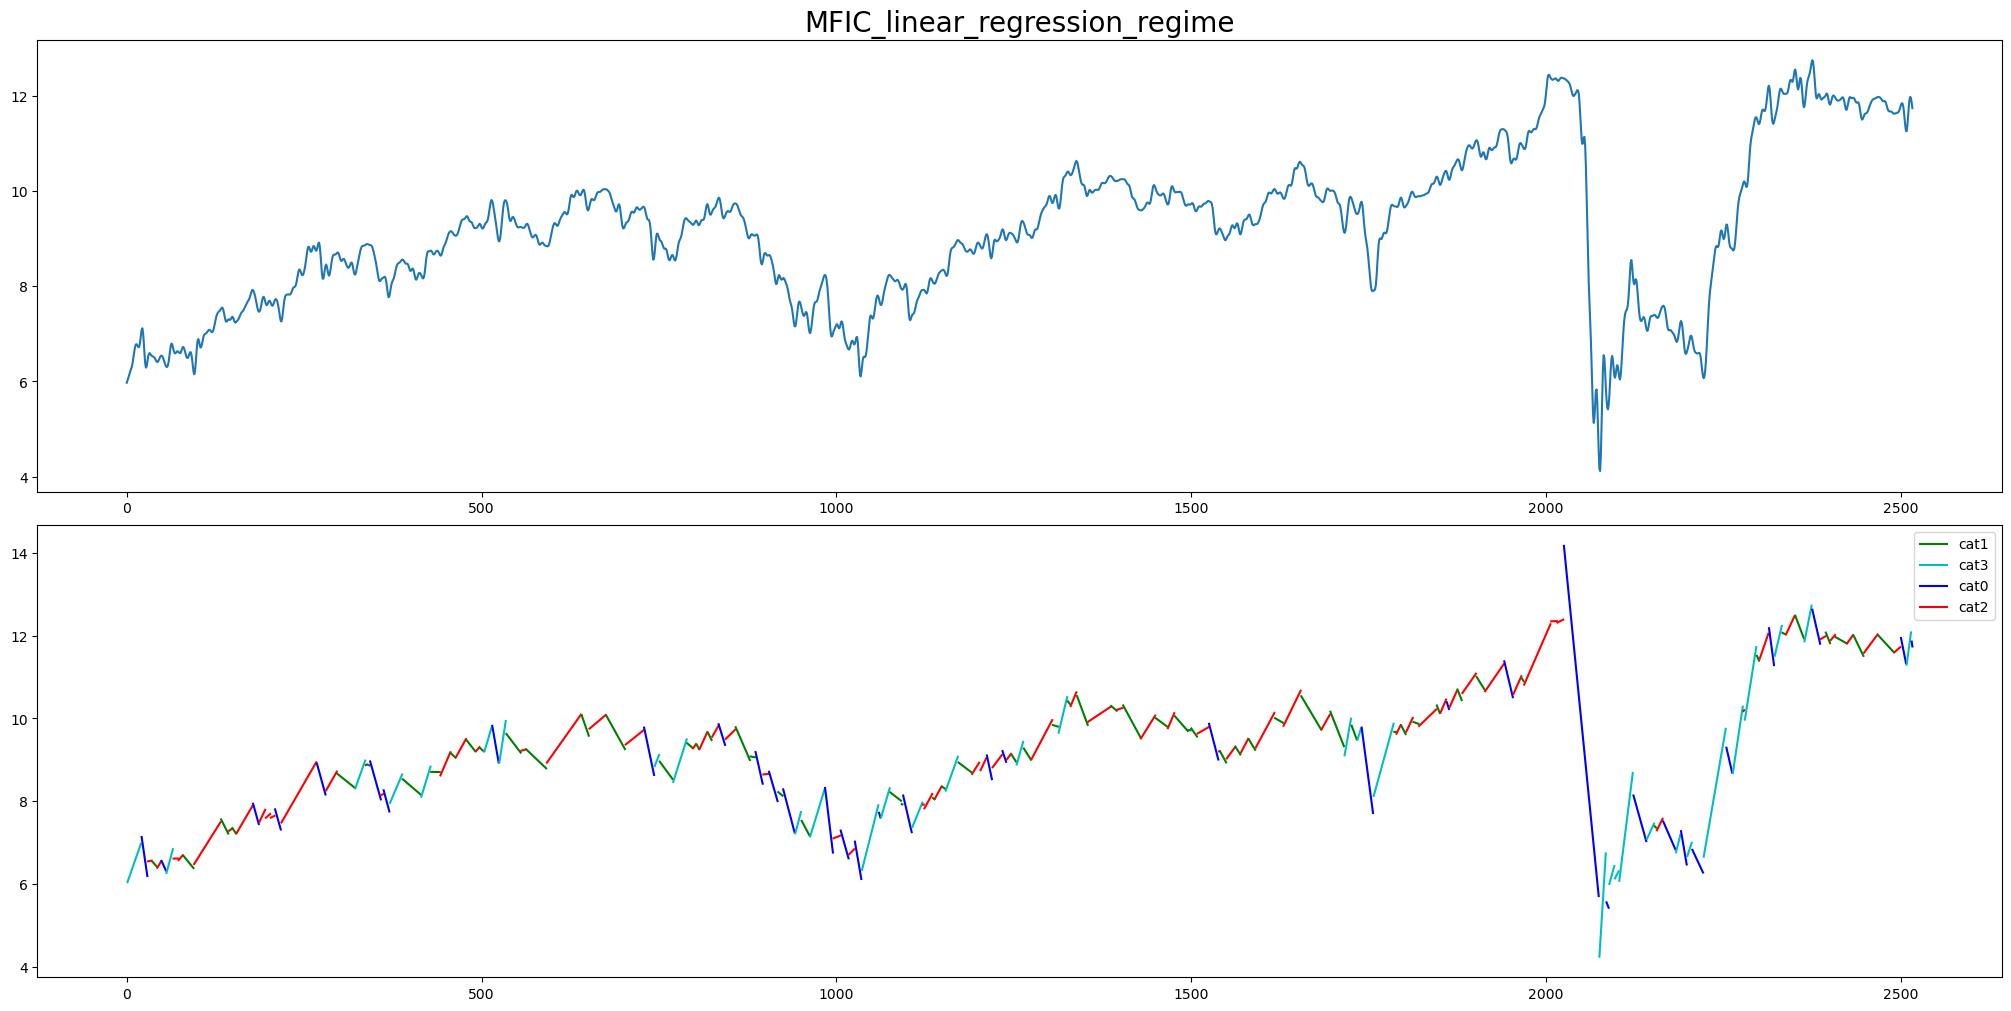

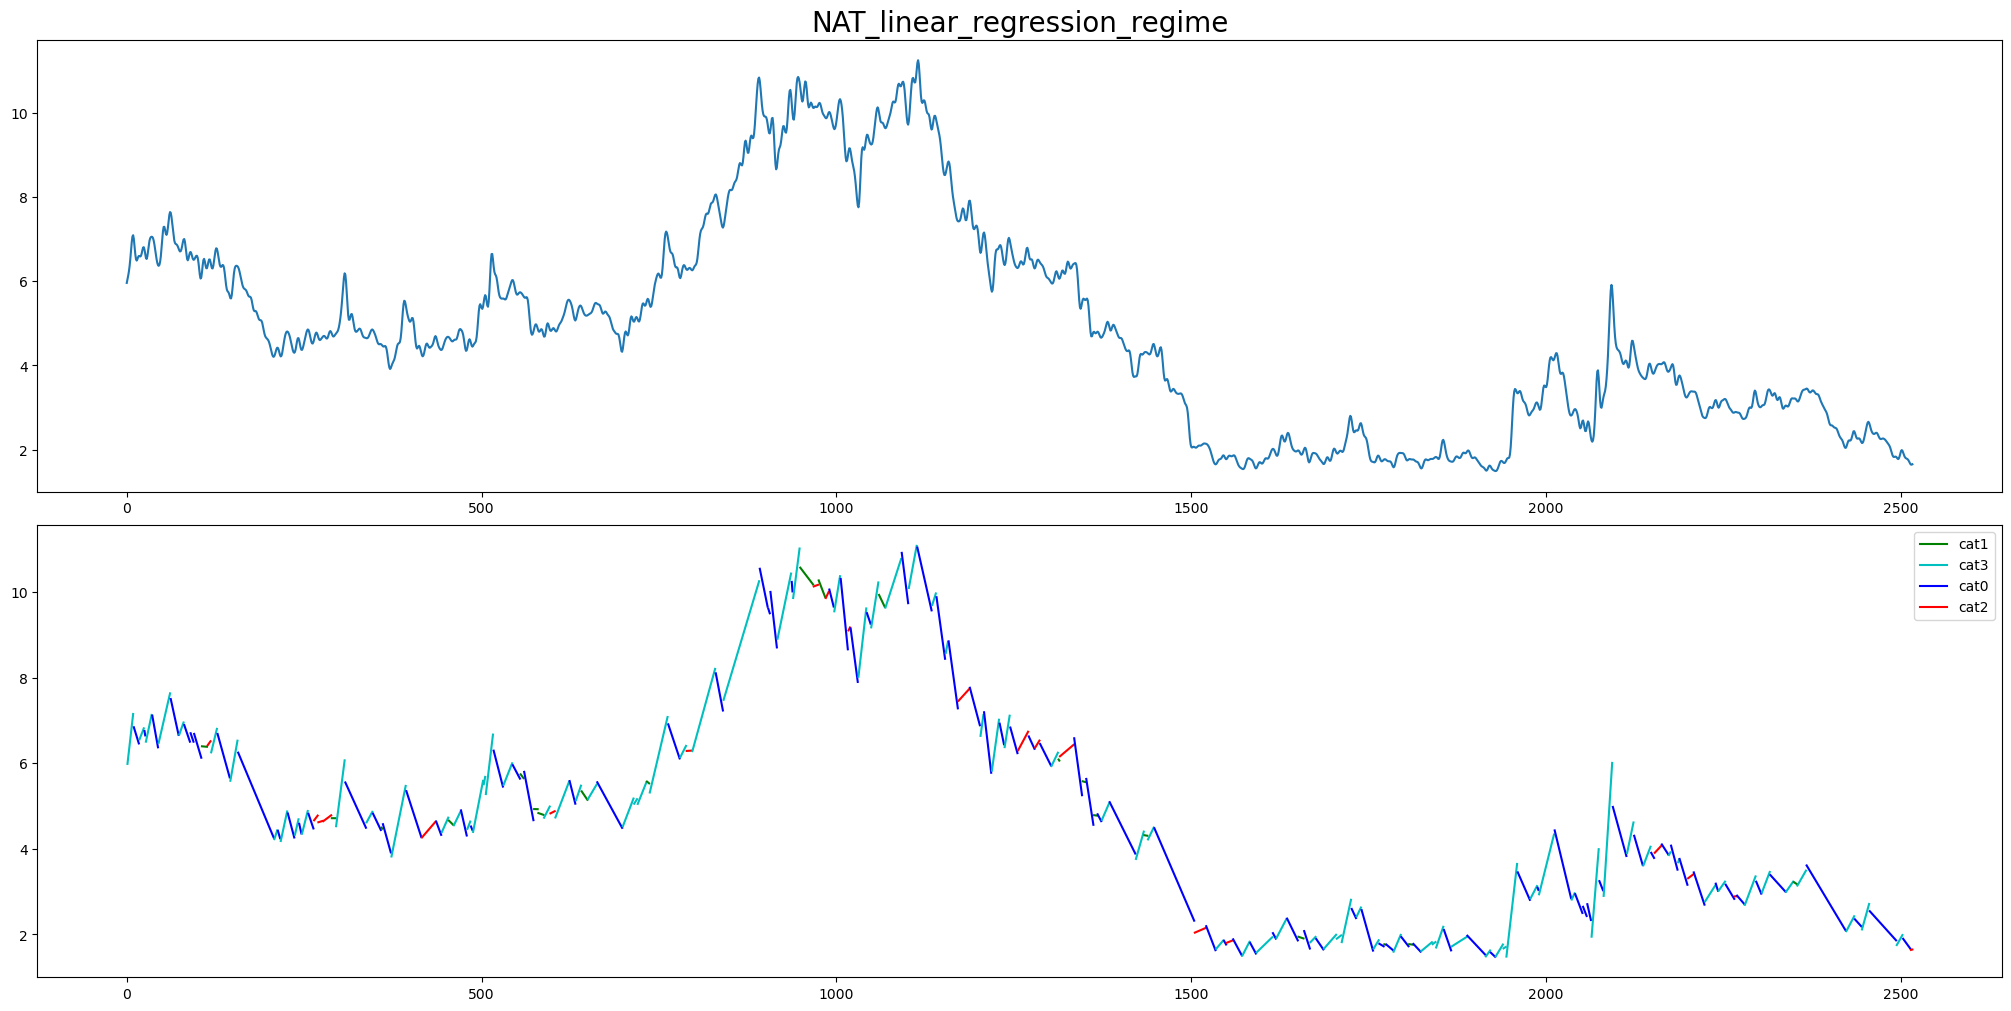

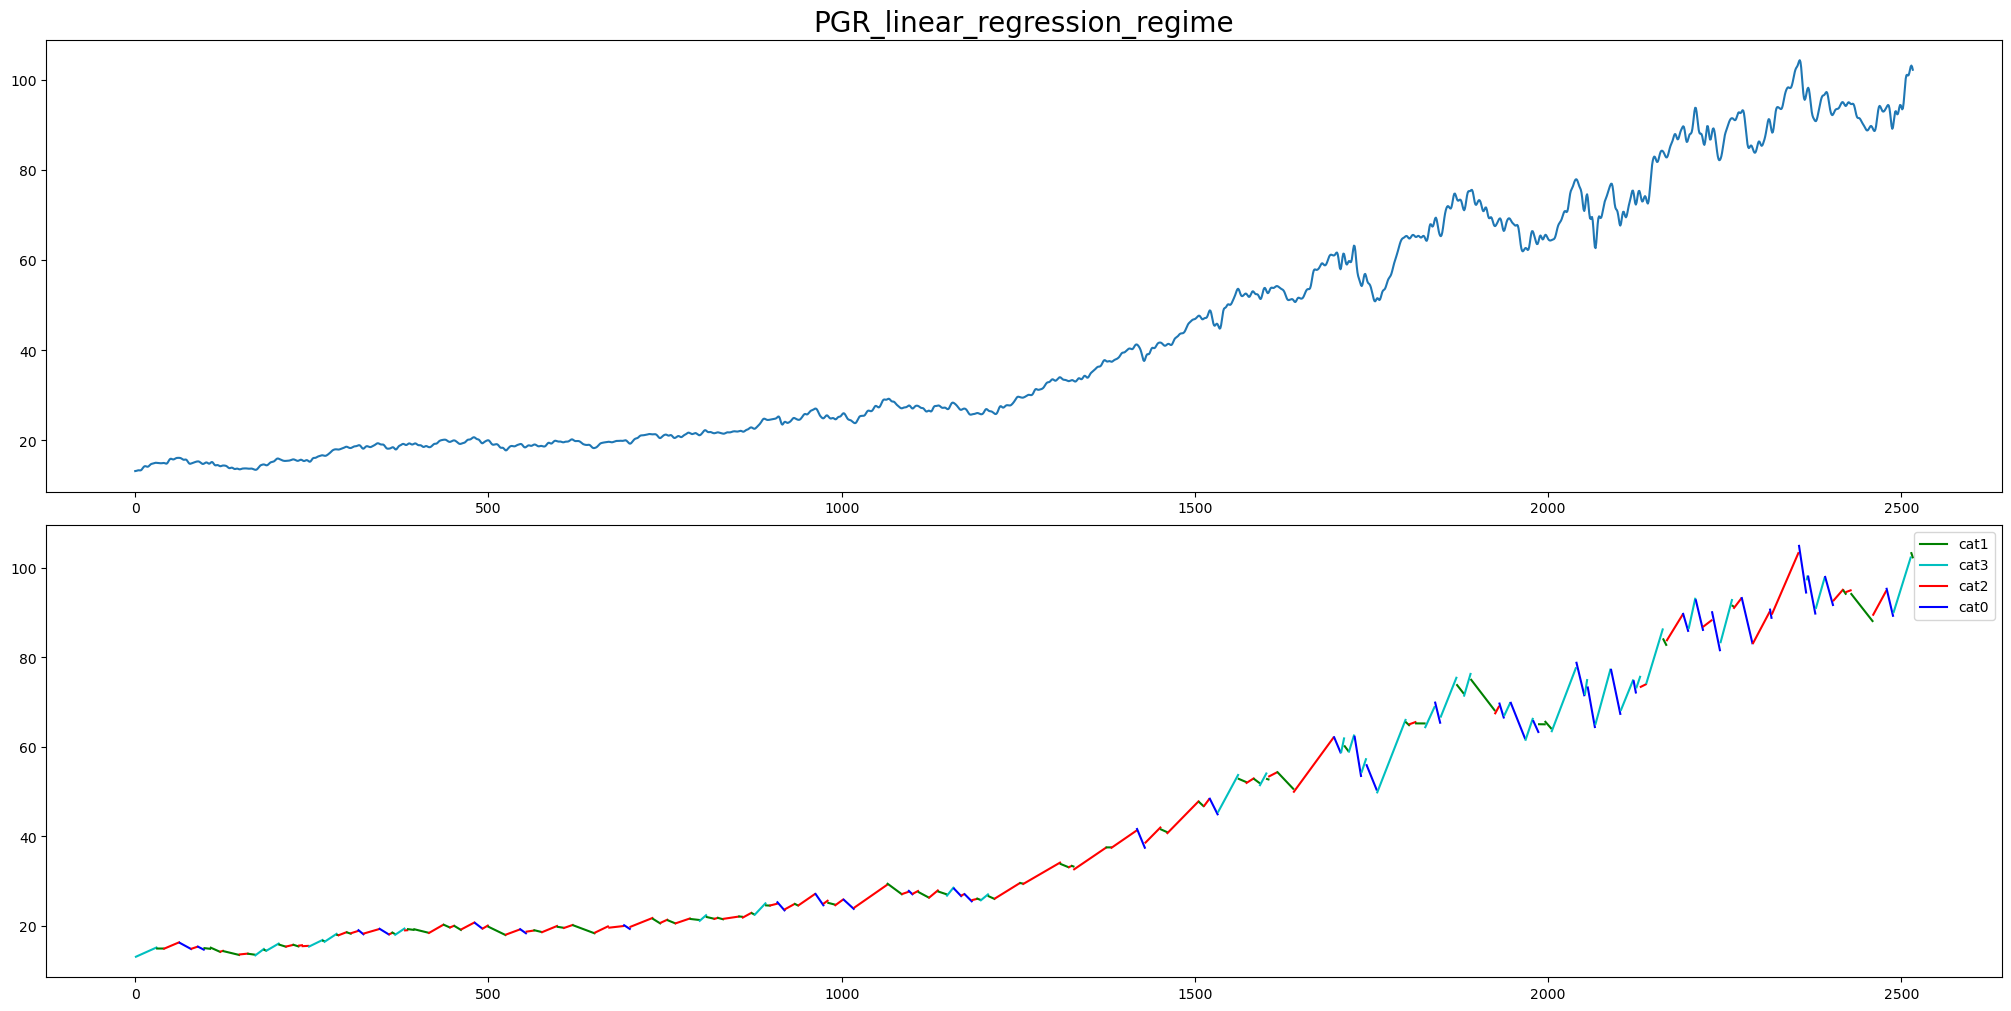

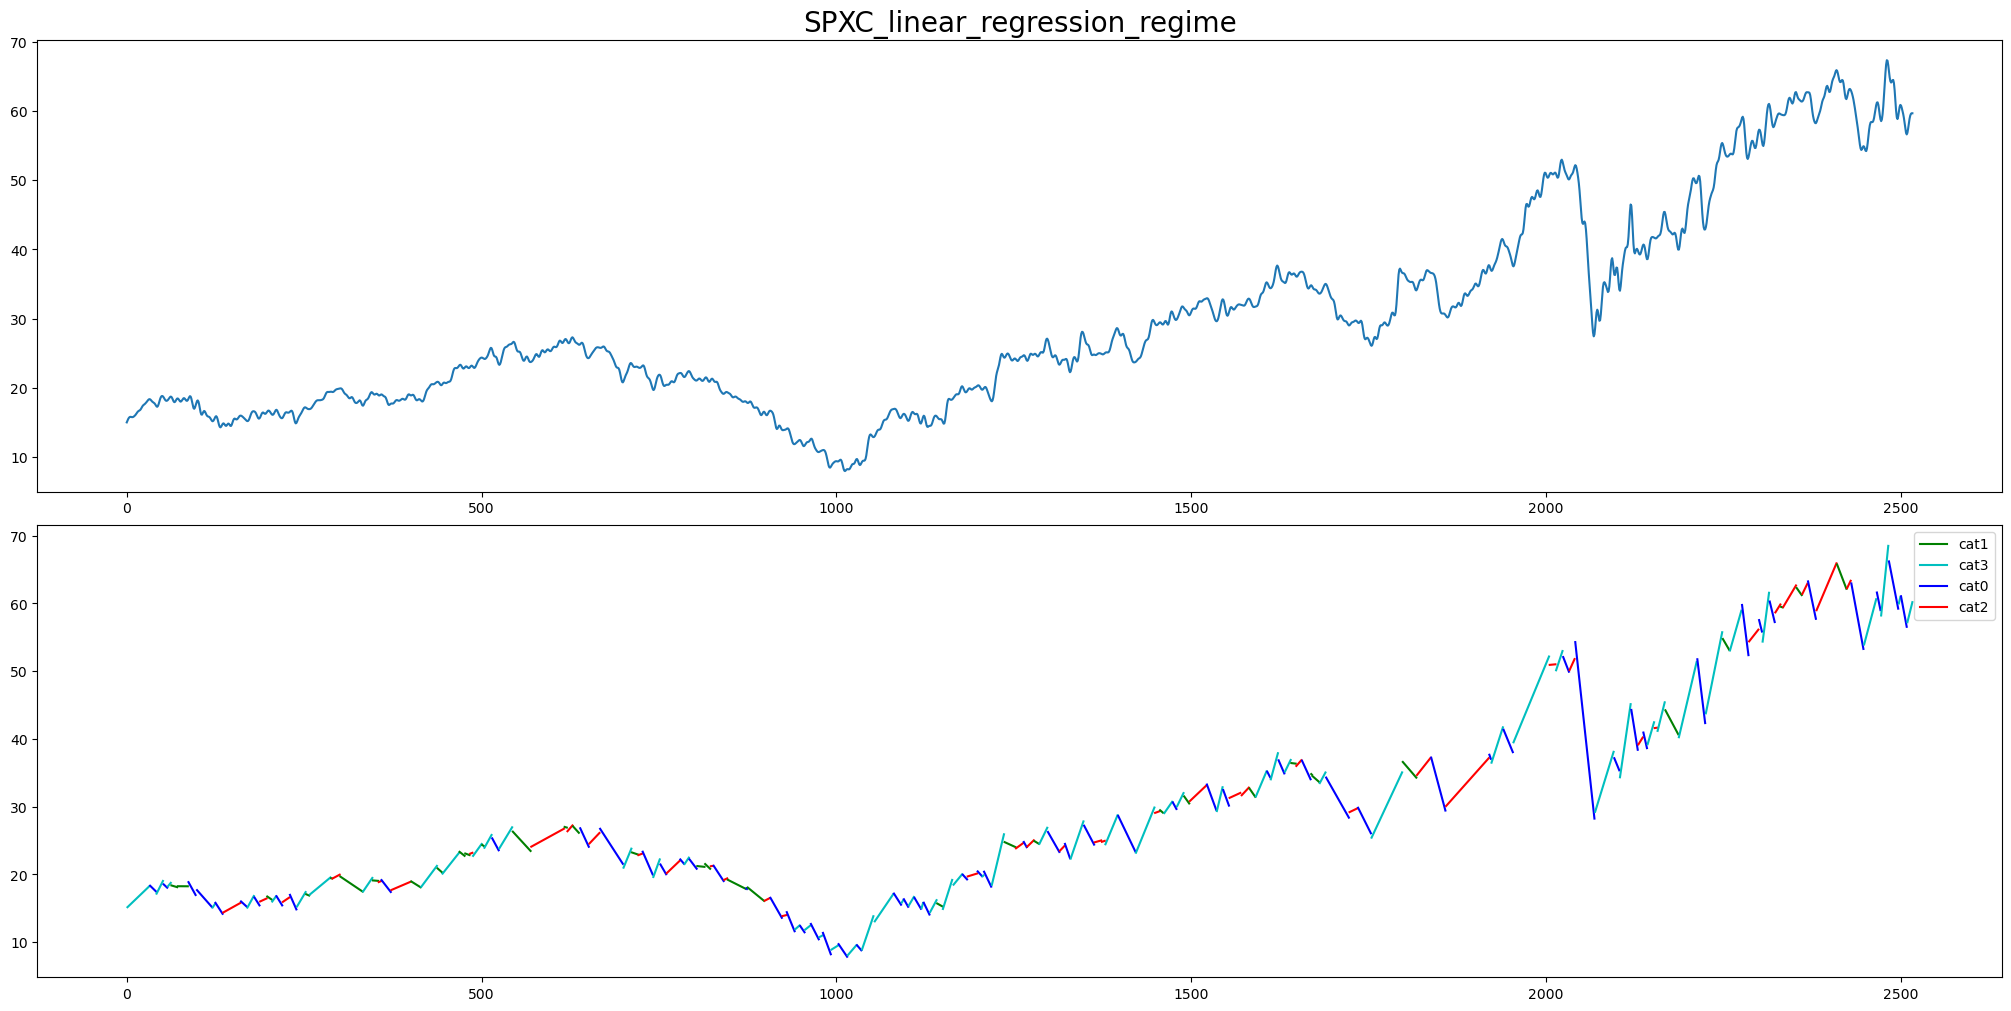

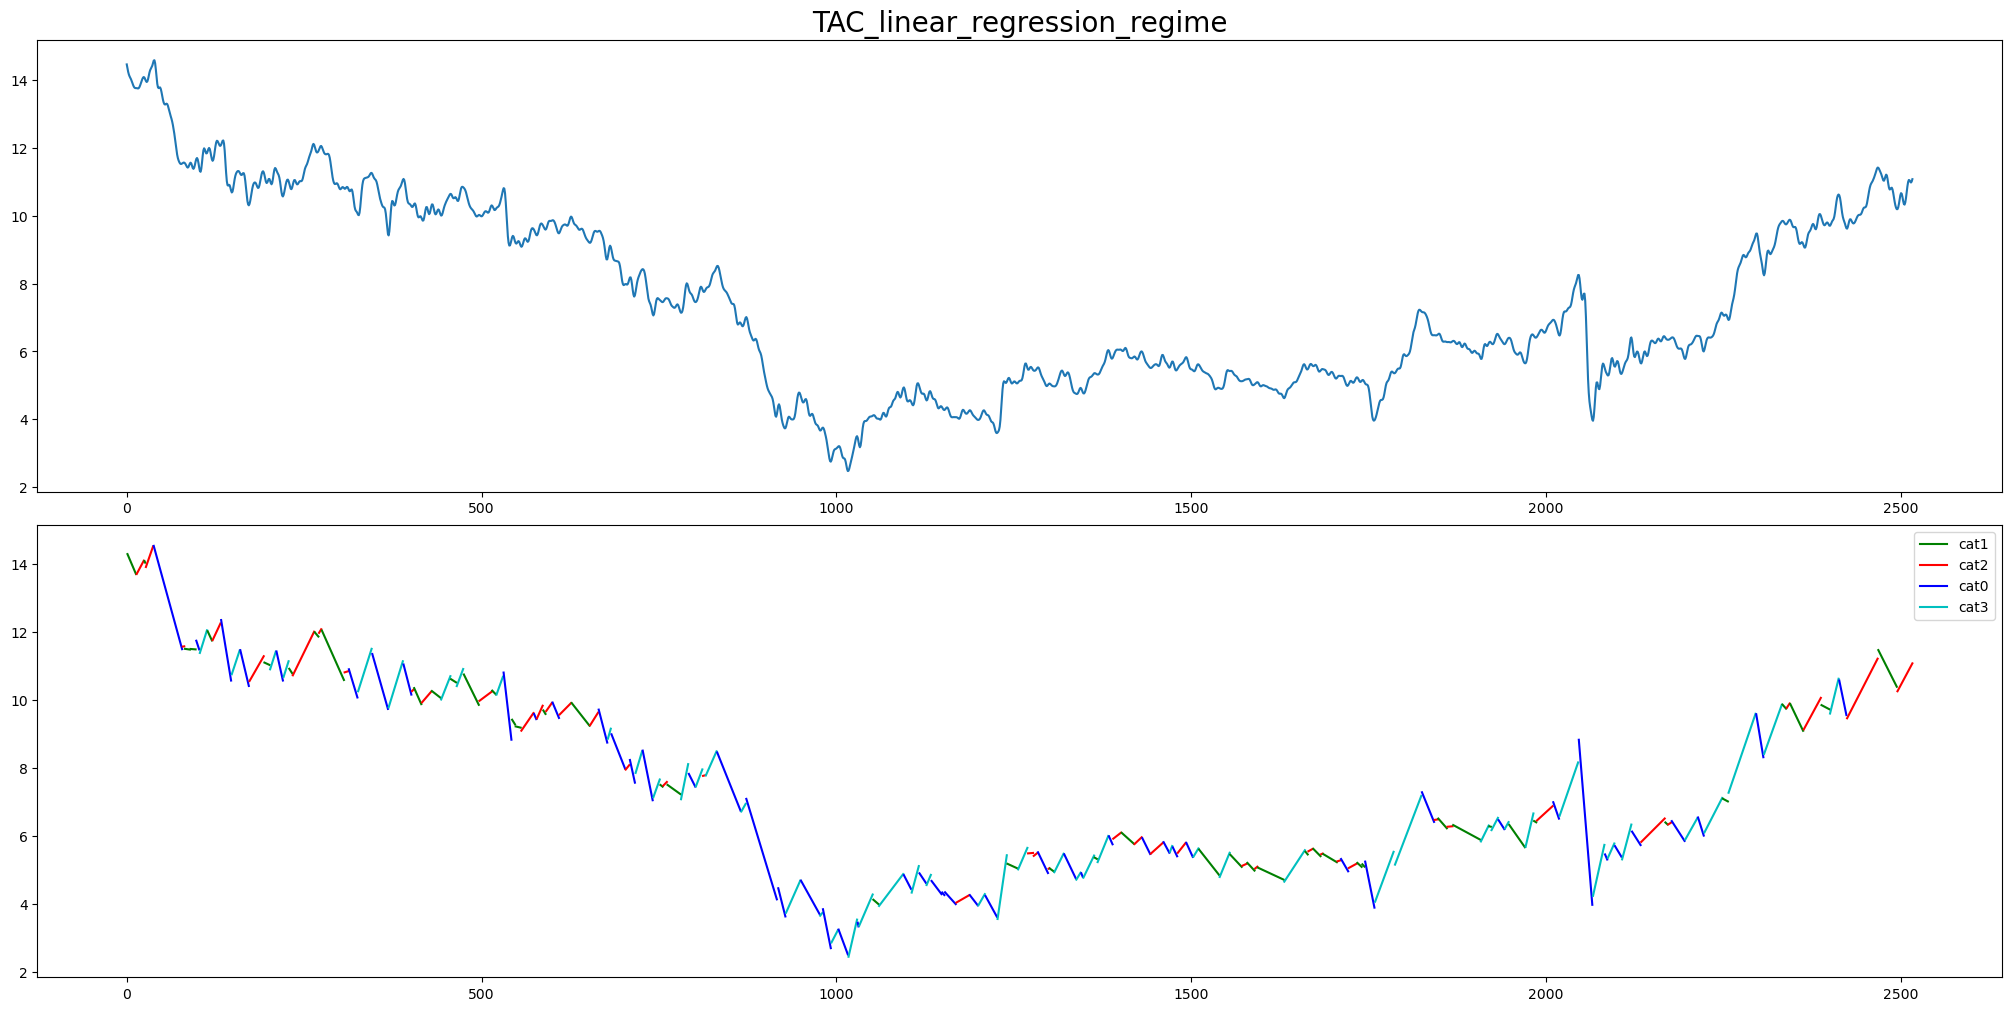

In [198]:
for tic in tics:
    turning_points=turning_points_dict[tic]
    coef_list=coef_list_dict[tic]
    y_pred_list=y_pred_dict[tic]
    norm_coef_list=norm_coef_list_dict[tic]
    label=linear_regession_label(data_dict[tic],y_pred_list,turning_points,-0.5,0.5,norm_coef_list)
    data_dict[tic]['label']=label
    linear_regession_plot(data_dict[tic],tic,y_pred_list,turning_points,-0.5,0.5,savefig=False,normalized_coef_list=norm_coef_list)